<a href="https://colab.research.google.com/github/Berchie-Sam/Practice/blob/main/Nsawam_GWL_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!python -V

Python 3.9.13


In [ ]:
import os
import pandas as pd
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, MaxPooling1D, Dense, Dropout, Conv1D, Flatten, LSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import numpy as np
import mlflow
import mlflow.sklearn
#import optuna
import seaborn as sns
import matplotlib.pyplot as plt



> a) Accessing TPU runtime



In [ ]:

# Check if the TPU system has already been initialized
if 'COLAB_TPU_ADDR' in os.environ:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
else:
    strategy = tf.distribute.OneDeviceStrategy('GPU:0')  # Use GPU if TPU is not available


In [ ]:
nsawam_url = r"D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Nsawam.csv"



> a) Accessing TPU runtime



In [ ]:

# Check if the TPU system has already been initialized
if 'COLAB_TPU_ADDR' in os.environ:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)
    strategy = tf.distribute.TPUStrategy(resolver)
else:
    strategy = tf.distribute.OneDeviceStrategy('GPU:0')  # Use GPU if TPU is not available


In [ ]:
# Set MLflow experiment name
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment(experiment_name='Nsawam_DL_GWL_experiment')


2024/01/28 13:48:25 INFO mlflow.tracking.fluent: Experiment with name 'Nsawam_DL_GWL_experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///D:/RGT/Code/Practice/Deep Learning for GWL Changes/mlruns/2', creation_time=1706478505049, experiment_id='2', last_update_time=1706478505049, lifecycle_stage='active', name='Nsawam_DL_GWL_experiment', tags={}>

In [ ]:
data = pd.read_csv(nsawam_url)

In [ ]:
data.describe()

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall,GWL
count,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000,4018.000000
mean,17.931745,25.830829,16.760309,81.424012,3.281715,1.579871,0.593357,412.935284,355.682902
std,3.505335,1.579171,1.507886,8.450076,4.153025,0.429514,0.090363,9.346183,24.685530
min,2.460000,21.050000,6.650000,35.440000,0.000000,0.520000,0.450000,369.300000,305.200000
25%,16.140000,24.580000,16.050000,76.750000,0.550000,1.270000,0.520000,407.800000,337.600000
50%,18.480000,25.770000,16.910000,83.310000,1.970000,1.540000,0.590000,412.925000,357.700000
75%,20.290000,26.970000,17.760000,87.940000,4.427500,1.880000,0.660000,418.400000,374.600000
max,26.550000,31.010000,20.080000,95.250000,66.020000,3.130000,0.880000,444.700000,396.700000


In [ ]:
data.isnull().sum()

Sunlight         0
Avg_Temp         0
Spec_Hum         0
Rel_Hum          0
Precipitation    0
Wind_Speed       0
Soil_Moisture    0
Rainfall         0
GWL              0
dtype: int64

In [ ]:
data.head(10)

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall,GWL
0,20.20,27.07,15.38,71.75,0.00,1.23,0.52,391.6,367.9
1,20.46,27.10,15.08,70.81,0.00,1.16,0.51,395.6,367.3
2,19.77,27.45,15.44,70.94,0.00,1.50,0.51,400.4,367.2
3,20.68,27.44,15.62,71.12,0.00,0.98,0.51,391.1,366.8
4,19.41,27.54,15.69,70.88,0.00,1.24,0.50,395.2,366.8
5,20.24,26.88,16.30,74.69,0.07,1.34,0.50,384.0,365.1
6,17.75,26.49,16.36,76.44,0.05,1.10,0.50,407.5,365.7
7,19.58,27.35,14.95,69.44,0.09,1.00,0.50,412.3,364.6
8,20.36,27.04,15.14,70.75,0.08,1.08,0.49,405.1,364.8
9,17.49,27.67,14.10,65.31,0.14,0.98,0.49,408.5,363.1


In [ ]:
data.tail(10)

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall,GWL
4008,19.00,26.92,16.91,77.56,0.15,0.94,0.54,403.99,322.3
4009,18.01,26.43,17.09,79.75,0.12,1.02,0.54,404.38,319.9
4010,18.91,27.60,15.69,70.56,0.12,0.83,0.54,404.82,322.5
4011,19.29,27.44,14.47,66.44,0.12,0.98,0.54,400.95,321.5
4012,19.64,26.15,12.27,61.75,0.03,1.69,0.53,391.77,322.3
4013,21.56,25.16,10.99,58.94,0.01,1.03,0.53,373.77,319.3
4014,19.50,26.98,15.14,70.81,0.10,0.90,0.53,393.96,321.9
4015,17.98,26.48,13.98,67.69,0.02,0.71,0.52,391.10,321.1
4016,18.19,26.44,15.08,72.88,0.03,1.38,0.52,391.29,322.1
4017,15.78,26.47,14.10,69.00,0.01,0.59,0.52,395.57,319.4


In [ ]:
data = data.astype('float32')

In [ ]:
data.head()

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall,GWL
0,20.200001,27.070000,15.38,71.750000,0.0,1.23,0.52,391.600006,367.899994
1,20.459999,27.100000,15.08,70.809998,0.0,1.16,0.51,395.600006,367.299988
2,19.770000,27.450001,15.44,70.940002,0.0,1.50,0.51,400.399994,367.200012
3,20.680000,27.440001,15.62,71.120003,0.0,0.98,0.51,391.100006,366.799988
4,19.410000,27.540001,15.69,70.879997,0.0,1.24,0.50,395.200012,366.799988


In [ ]:
corr_matrix = data.corr()
print(corr_matrix)

               Sunlight  Avg_Temp  Spec_Hum   Rel_Hum  Precipitation  \
Sunlight       1.000000  0.340553  0.053377 -0.223001      -0.226715   
Avg_Temp       0.340553  1.000000  0.040179 -0.703615      -0.283887   
Spec_Hum       0.053377  0.040179  1.000000  0.673877       0.364204   
Rel_Hum       -0.223001 -0.703615  0.673877  1.000000       0.479617   
Precipitation -0.226715 -0.283887  0.364204  0.479617       1.000000   
Wind_Speed    -0.215752 -0.232301 -0.061832  0.126762       0.094341   
Soil_Moisture -0.172860 -0.738336  0.294026  0.765728       0.312530   
Rainfall      -0.182862  0.244997  0.517429  0.178562       0.240782   
GWL           -0.004131 -0.119961  0.056622  0.119972       0.040430   

               Wind_Speed  Soil_Moisture  Rainfall       GWL  
Sunlight        -0.215752      -0.172860 -0.182862 -0.004131  
Avg_Temp        -0.232301      -0.738336  0.244997 -0.119961  
Spec_Hum        -0.061832       0.294026  0.517429  0.056622  
Rel_Hum          0.126762  

In [ ]:
correlation_with_GWL = corr_matrix['GWL']
print('\nCorrelation with GWL:\n', correlation_with_GWL)


Correlation with GWL:
 Sunlight        -0.004131
Avg_Temp        -0.119961
Spec_Hum         0.056622
Rel_Hum          0.119972
Precipitation    0.040430
Wind_Speed      -0.028349
Soil_Moisture    0.157812
Rainfall        -0.050964
GWL              1.000000
Name: GWL, dtype: float64


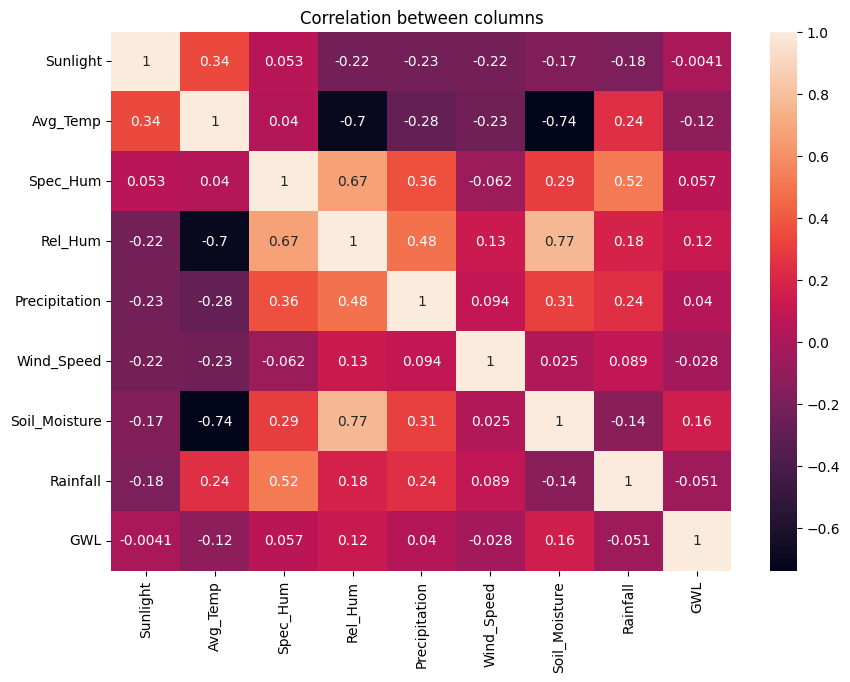

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation between columns')
plt.show()

# Lighter color -> higher correlation value
# Darker color -> lower correlation value

In [ ]:
x = data.drop(columns = 'GWL')
x

,Sunlight,Avg_Temp,Spec_Hum,Rel_Hum,Precipitation,Wind_Speed,Soil_Moisture,Rainfall
0,20.200001,27.070000,15.38,71.750000,0.00,1.23,0.52,391.600006
1,20.459999,27.100000,15.08,70.809998,0.00,1.16,0.51,395.600006
2,19.770000,27.450001,15.44,70.940002,0.00,1.50,0.51,400.399994
3,20.680000,27.440001,15.62,71.120003,0.00,0.98,0.51,391.100006
4,19.410000,27.540001,15.69,70.879997,0.00,1.24,0.50,395.200012
...,...,...,...,...,...,...,...,...
4013,21.559999,25.160000,10.99,58.939999,0.01,1.03,0.53,373.769989
4014,19.500000,26.980000,15.14,70.809998,0.10,0.90,0.53,393.959991
4015,17.980000,26.480000,13.98,67.690002,0.02,0.71,0.52,391.100006
4016,18.190001,26.440001,15.08,72.879997,0.03,1.38,0.52,391.290009


In [ ]:
y = data['GWL']
y

0       367.899994
1       367.299988
2       367.200012
3       366.799988
4       366.799988
           ...    
4013    319.299988
4014    321.899994
4015    321.100006
4016    322.100006
4017    319.399994
Name: GWL, Length: 4018, dtype: float32

In [ ]:
data.shape

(4018, 9)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42) # Train (80%) and Test (20%)

In [ ]:
x_test, x_val, y_test, y_val = train_test_split(x_train, y_train, test_size = 0.5, random_state = 42) # Validation (10%) and Test (10%)

In [ ]:
print('x_train', x_train.shape)
print('x_test', x_test.shape)
print('x_val', x_val.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print('y_val', y_val.shape)

x_train (3214, 8)
x_test (1607, 8)
x_val (1607, 8)
y_train (3214,)
y_test (1607,)
y_val (1607,)


In [ ]:
# Scaling data into numpy arrays
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [ ]:
x_train

array([[ 0.03597067,  0.08722618,  1.1389925 , ..., -1.3277869 ,
         1.7339075 ,  0.09085408],
       [-2.806439  , -0.16129513,  0.6611977 , ...,  1.4816014 ,
        -0.48906845,  0.37117654],
       [ 1.053164  , -0.44167638, -2.853542  , ..., -0.81698895,
         0.28897312, -3.157935  ],
       ...,
       [-0.69755435,  0.3038852 ,  1.1782631 , ...,  1.4351652 ,
        -0.48906845,  2.6063173 ],
       [ 0.29385105, -1.0534197 , -0.9750871 , ...,  2.0852716 ,
        -0.04447364, -1.2308339 ],
       [-0.33938774, -0.4353039 , -0.05876786, ..., -1.0723879 ,
         0.28897312, -0.17028667]], dtype=float32)

In [ ]:
x_test

array([[-0.04425829, -0.9705789 ,  0.26194382, ...,  1.3887291 ,
         1.5116102 ,  0.04821646],
       [ 1.1964307 ,  0.9729783 ,  0.8248262 , ...,  1.0868938 ,
        -0.8225152 ,  0.12495961],
       [ 0.24514037, -0.8431332 ,  0.22267333, ..., -1.0491699 ,
         0.8447173 , -0.88762194],
       ...,
       [ 0.29385105,  1.2023822 , -0.09803834, ..., -0.3990636 ,
        -0.8225152 ,  0.5918135 ],
       [ 0.50302017, -0.01473085,  0.8248262 , ..., -1.2349147 ,
         2.0673535 , -0.6744469 ],
       [ 0.5431347 , -0.24413477,  0.7790104 , ...,  0.34391522,
         0.8447173 ,  1.5191263 ]], dtype=float32)

In [ ]:
x_val

array([[-0.6459783 ,  0.9474897 , -1.0928998 , ..., -0.35262746,
        -1.1559613 , -2.296709  ],
       [ 0.9958572 ,  0.4759369 ,  0.90336716, ...,  0.22782461,
         0.06667572, -0.3450918 ],
       [-0.27921548, -1.5440886 ,  0.01977437, ...,  0.25104296,
         1.9562049 , -0.02852669],
       ...,
       [-1.7949767 , -1.4548753 , -0.29439327, ...,  2.0852716 ,
         0.95586604,  1.3379263 ],
       [-2.8608804 , -0.66470784,  1.0211799 , ..., -0.46871775,
         1.4004614 , -0.10100543],
       [ 0.5374039 , -0.63921916,  0.90336716, ...,  0.2974791 ,
         1.9562049 ,  1.4231982 ]], dtype=float32)

In [ ]:
print(x_train.shape[1])

epochs = 2000
batch_size = 50
patience = 100

8


### 1. Feed-Forward Neural Network

2024/01/28 14:10:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmp0b9t8g0w\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmp0b9t8g0w\model\data\model\assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1000)              9000      
                                                                 
 dense_5 (Dense)             (None, 500)               500500    
                                                                 
 dense_6 (Dense)             (None, 250)               125250    
                                                                 
 dense_7 (Dense)             (None, 1)                 251       
                                                                 
Total params: 635001 (2.42 MB)
Trainable params: 635001 (2.42 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2000
65/65 [==============================] - 1s 8ms/step - loss: 17660.8828 - mae: 93.6583 - val_loss: 3497.0933 - val_mae: 46.5692
Epoch 2/2

65/65 [==============================] - 0s 6ms/step - loss: 762.6539 - mae: 22.6049 - val_loss: 1921.3242 - val_mae: 36.9314
Epoch 53/2000
65/65 [==============================] - 0s 5ms/step - loss: 749.7707 - mae: 22.1084 - val_loss: 1020.0583 - val_mae: 26.1461
Epoch 54/2000
65/65 [==============================] - 0s 6ms/step - loss: 762.8875 - mae: 22.2243 - val_loss: 547.1001 - val_mae: 18.8253
Epoch 55/2000
65/65 [==============================] - 0s 5ms/step - loss: 751.2058 - mae: 22.1425 - val_loss: 784.7109 - val_mae: 22.5381
Epoch 56/2000
65/65 [==============================] - 0s 6ms/step - loss: 767.9696 - mae: 22.2778 - val_loss: 894.7007 - val_mae: 23.8827
Epoch 57/2000
65/65 [==============================] - 0s 6ms/step - loss: 768.1597 - mae: 22.3732 - val_loss: 829.2805 - val_mae: 23.6299
Epoch 58/2000
65/65 [==============================] - 0s 6ms/step - loss: 736.9974 - mae: 21.8934 - val_loss: 1071.4850 - val_mae: 26.1703
Epoch 59/2000
65/65 [=================

Epoch 111/2000
65/65 [==============================] - 0s 7ms/step - loss: 635.7018 - mae: 20.3121 - val_loss: 558.8252 - val_mae: 19.2988
Epoch 112/2000
65/65 [==============================] - 0s 7ms/step - loss: 613.6370 - mae: 19.9370 - val_loss: 925.3350 - val_mae: 25.2919
Epoch 113/2000
65/65 [==============================] - 0s 7ms/step - loss: 652.3491 - mae: 20.6278 - val_loss: 1143.4332 - val_mae: 27.5081
Epoch 114/2000
65/65 [==============================] - 0s 7ms/step - loss: 628.6881 - mae: 20.0182 - val_loss: 1221.3893 - val_mae: 29.0473
Epoch 115/2000
65/65 [==============================] - 0s 7ms/step - loss: 615.7333 - mae: 20.0620 - val_loss: 905.9404 - val_mae: 25.1445
Epoch 116/2000
65/65 [==============================] - 0s 7ms/step - loss: 634.4179 - mae: 20.2177 - val_loss: 527.5210 - val_mae: 18.5604
Epoch 117/2000
65/65 [==============================] - 1s 8ms/step - loss: 619.2471 - mae: 20.1314 - val_loss: 591.3991 - val_mae: 19.7834
Epoch 118/2000
65/

65/65 [==============================] - 1s 8ms/step - loss: 546.9368 - mae: 18.7205 - val_loss: 694.9664 - val_mae: 21.3392
Epoch 170/2000
65/65 [==============================] - 1s 8ms/step - loss: 538.6412 - mae: 18.6346 - val_loss: 822.7404 - val_mae: 23.7650
Epoch 171/2000
65/65 [==============================] - 1s 8ms/step - loss: 552.6466 - mae: 18.8403 - val_loss: 508.8680 - val_mae: 18.1457
Epoch 172/2000
65/65 [==============================] - 1s 8ms/step - loss: 539.1237 - mae: 18.6175 - val_loss: 518.1991 - val_mae: 18.5416
Epoch 173/2000
65/65 [==============================] - 1s 8ms/step - loss: 562.4028 - mae: 19.1690 - val_loss: 749.8205 - val_mae: 22.4052
Epoch 174/2000
65/65 [==============================] - 1s 10ms/step - loss: 539.8646 - mae: 18.6674 - val_loss: 511.1382 - val_mae: 18.1950
Epoch 175/2000
65/65 [==============================] - 0s 7ms/step - loss: 542.1379 - mae: 18.7579 - val_loss: 609.0424 - val_mae: 19.9593
Epoch 176/2000
65/65 [============

65/65 [==============================] - 1s 8ms/step - loss: 508.6254 - mae: 18.0492 - val_loss: 651.6218 - val_mae: 20.3461
Epoch 228/2000
65/65 [==============================] - 1s 8ms/step - loss: 494.1500 - mae: 17.6960 - val_loss: 840.4085 - val_mae: 23.4783
Epoch 229/2000
65/65 [==============================] - 0s 7ms/step - loss: 483.9460 - mae: 17.5902 - val_loss: 816.0726 - val_mae: 23.0240
Epoch 230/2000
65/65 [==============================] - 1s 9ms/step - loss: 481.7677 - mae: 17.5090 - val_loss: 741.1749 - val_mae: 22.1722
Epoch 231/2000
65/65 [==============================] - 1s 9ms/step - loss: 494.0287 - mae: 17.8929 - val_loss: 570.2538 - val_mae: 19.1096
Epoch 232/2000
65/65 [==============================] - 0s 7ms/step - loss: 493.0338 - mae: 17.8102 - val_loss: 702.8597 - val_mae: 21.3501
Epoch 233/2000
65/65 [==============================] - 0s 8ms/step - loss: 495.3842 - mae: 17.8817 - val_loss: 474.2782 - val_mae: 17.4552
Epoch 234/2000
65/65 [=============

65/65 [==============================] - 0s 7ms/step - loss: 429.4591 - mae: 16.4156 - val_loss: 369.2148 - val_mae: 15.3359
Epoch 286/2000
65/65 [==============================] - 0s 7ms/step - loss: 439.1430 - mae: 16.6138 - val_loss: 559.9119 - val_mae: 18.8740
Epoch 287/2000
65/65 [==============================] - 0s 7ms/step - loss: 449.0228 - mae: 16.9375 - val_loss: 463.3963 - val_mae: 17.1689
Epoch 288/2000
65/65 [==============================] - 0s 7ms/step - loss: 426.7291 - mae: 16.4906 - val_loss: 381.3626 - val_mae: 15.6773
Epoch 289/2000
65/65 [==============================] - 1s 8ms/step - loss: 441.0248 - mae: 16.8301 - val_loss: 398.8447 - val_mae: 15.8390
Epoch 290/2000
65/65 [==============================] - 0s 7ms/step - loss: 425.4914 - mae: 16.3935 - val_loss: 574.0928 - val_mae: 19.9039
Epoch 291/2000
65/65 [==============================] - 0s 7ms/step - loss: 434.6863 - mae: 16.5815 - val_loss: 365.3638 - val_mae: 15.3838
Epoch 292/2000
65/65 [=============

65/65 [==============================] - 1s 8ms/step - loss: 374.5956 - mae: 15.4237 - val_loss: 448.3194 - val_mae: 16.9310
Epoch 344/2000
65/65 [==============================] - 0s 7ms/step - loss: 379.5269 - mae: 15.3929 - val_loss: 350.9139 - val_mae: 14.9911
Epoch 345/2000
65/65 [==============================] - 1s 8ms/step - loss: 380.6394 - mae: 15.4962 - val_loss: 448.9120 - val_mae: 17.0789
Epoch 346/2000
65/65 [==============================] - 0s 7ms/step - loss: 371.8720 - mae: 15.3146 - val_loss: 405.9955 - val_mae: 16.3204
Epoch 347/2000
65/65 [==============================] - 0s 8ms/step - loss: 381.4931 - mae: 15.4866 - val_loss: 313.3778 - val_mae: 13.9844
Epoch 348/2000
65/65 [==============================] - 0s 7ms/step - loss: 372.2609 - mae: 15.2688 - val_loss: 422.4337 - val_mae: 16.5277
Epoch 349/2000
65/65 [==============================] - 1s 8ms/step - loss: 371.4836 - mae: 15.4927 - val_loss: 466.0733 - val_mae: 17.5894
Epoch 350/2000
65/65 [=============

65/65 [==============================] - 1s 8ms/step - loss: 330.9383 - mae: 14.3328 - val_loss: 492.5835 - val_mae: 18.4632
Epoch 402/2000
65/65 [==============================] - 1s 9ms/step - loss: 332.1112 - mae: 14.3630 - val_loss: 265.5134 - val_mae: 12.6451
Epoch 403/2000
65/65 [==============================] - 1s 10ms/step - loss: 314.1556 - mae: 13.9374 - val_loss: 372.9244 - val_mae: 15.5848
Epoch 404/2000
65/65 [==============================] - 1s 9ms/step - loss: 319.2892 - mae: 14.0892 - val_loss: 355.2490 - val_mae: 14.7543
Epoch 405/2000
65/65 [==============================] - 1s 9ms/step - loss: 333.1640 - mae: 14.3911 - val_loss: 404.6358 - val_mae: 16.2060
Epoch 406/2000
65/65 [==============================] - 1s 9ms/step - loss: 307.2894 - mae: 13.7345 - val_loss: 341.9807 - val_mae: 14.9756
Epoch 407/2000
65/65 [==============================] - 1s 8ms/step - loss: 330.1192 - mae: 14.3198 - val_loss: 301.8494 - val_mae: 13.5274
Epoch 408/2000
65/65 [============

65/65 [==============================] - 1s 9ms/step - loss: 267.3891 - mae: 12.7757 - val_loss: 404.5523 - val_mae: 16.4035
Epoch 460/2000
65/65 [==============================] - 1s 8ms/step - loss: 269.8461 - mae: 12.8556 - val_loss: 528.7327 - val_mae: 18.1516
Epoch 461/2000
65/65 [==============================] - 0s 8ms/step - loss: 284.5323 - mae: 13.3583 - val_loss: 221.8780 - val_mae: 11.6348
Epoch 462/2000
65/65 [==============================] - 1s 9ms/step - loss: 268.1532 - mae: 12.9483 - val_loss: 315.5667 - val_mae: 14.3259
Epoch 463/2000
65/65 [==============================] - 0s 7ms/step - loss: 277.1047 - mae: 13.0239 - val_loss: 246.3682 - val_mae: 12.3230
Epoch 464/2000
65/65 [==============================] - 0s 8ms/step - loss: 271.1946 - mae: 13.0185 - val_loss: 225.1363 - val_mae: 11.6326
Epoch 465/2000
65/65 [==============================] - 1s 8ms/step - loss: 283.6937 - mae: 13.2640 - val_loss: 380.0819 - val_mae: 15.7783
Epoch 466/2000
65/65 [=============

65/65 [==============================] - 1s 8ms/step - loss: 231.3916 - mae: 12.0199 - val_loss: 266.2383 - val_mae: 12.6620
Epoch 518/2000
65/65 [==============================] - 1s 9ms/step - loss: 232.0893 - mae: 11.9787 - val_loss: 278.2106 - val_mae: 13.2720
Epoch 519/2000
65/65 [==============================] - 0s 7ms/step - loss: 227.3812 - mae: 11.9288 - val_loss: 173.0110 - val_mae: 10.2438
Epoch 520/2000
65/65 [==============================] - 1s 8ms/step - loss: 232.3331 - mae: 12.1116 - val_loss: 250.5834 - val_mae: 12.4386
Epoch 521/2000
65/65 [==============================] - 1s 8ms/step - loss: 225.4213 - mae: 11.8976 - val_loss: 307.5868 - val_mae: 14.2041
Epoch 522/2000
65/65 [==============================] - 1s 8ms/step - loss: 222.5206 - mae: 11.7160 - val_loss: 336.8016 - val_mae: 14.8926
Epoch 523/2000
65/65 [==============================] - 0s 8ms/step - loss: 229.1527 - mae: 12.1042 - val_loss: 218.8839 - val_mae: 11.6560
Epoch 524/2000
65/65 [=============

Epoch 576/2000
65/65 [==============================] - 1s 8ms/step - loss: 199.9088 - mae: 11.1256 - val_loss: 142.9812 - val_mae: 9.6069
Epoch 577/2000
65/65 [==============================] - 1s 8ms/step - loss: 185.9216 - mae: 10.6814 - val_loss: 183.9317 - val_mae: 10.8081
Epoch 578/2000
65/65 [==============================] - 1s 8ms/step - loss: 196.4027 - mae: 11.1270 - val_loss: 304.7051 - val_mae: 14.3331
Epoch 579/2000
65/65 [==============================] - 0s 8ms/step - loss: 182.9137 - mae: 10.6077 - val_loss: 184.6445 - val_mae: 10.2381
Epoch 580/2000
65/65 [==============================] - 1s 8ms/step - loss: 192.0887 - mae: 10.8058 - val_loss: 195.5631 - val_mae: 10.6533
Epoch 581/2000
65/65 [==============================] - 1s 8ms/step - loss: 180.4142 - mae: 10.4769 - val_loss: 141.0061 - val_mae: 9.1928
Epoch 582/2000
65/65 [==============================] - 1s 8ms/step - loss: 192.5168 - mae: 10.8210 - val_loss: 182.6337 - val_mae: 10.5519
Epoch 583/2000
65/65 [

Epoch 635/2000
65/65 [==============================] - 1s 8ms/step - loss: 161.3666 - mae: 9.9772 - val_loss: 205.9526 - val_mae: 11.5359
Epoch 636/2000
65/65 [==============================] - 0s 8ms/step - loss: 161.7106 - mae: 10.0442 - val_loss: 135.7778 - val_mae: 9.2924
Epoch 637/2000
65/65 [==============================] - 1s 8ms/step - loss: 160.6448 - mae: 9.8049 - val_loss: 250.5177 - val_mae: 12.5824
Epoch 638/2000
65/65 [==============================] - 0s 8ms/step - loss: 162.6433 - mae: 10.0915 - val_loss: 144.9211 - val_mae: 9.1631
Epoch 639/2000
65/65 [==============================] - 0s 8ms/step - loss: 161.6884 - mae: 9.9875 - val_loss: 292.7792 - val_mae: 13.9330
Epoch 640/2000
65/65 [==============================] - 1s 8ms/step - loss: 164.3806 - mae: 10.1459 - val_loss: 155.1545 - val_mae: 9.7608
Epoch 641/2000
65/65 [==============================] - 1s 8ms/step - loss: 161.8077 - mae: 10.0990 - val_loss: 176.5741 - val_mae: 10.1355
Epoch 642/2000
65/65 [====

65/65 [==============================] - 1s 8ms/step - loss: 137.6623 - mae: 9.1934 - val_loss: 219.7971 - val_mae: 12.2027
Epoch 695/2000
65/65 [==============================] - 1s 8ms/step - loss: 141.8932 - mae: 9.2292 - val_loss: 117.6742 - val_mae: 8.3549
Epoch 696/2000
65/65 [==============================] - 0s 8ms/step - loss: 137.5609 - mae: 9.2117 - val_loss: 180.5080 - val_mae: 11.0339
Epoch 697/2000
65/65 [==============================] - 0s 8ms/step - loss: 145.7613 - mae: 9.5159 - val_loss: 161.7965 - val_mae: 10.2433
Epoch 698/2000
65/65 [==============================] - 1s 8ms/step - loss: 142.7320 - mae: 9.3121 - val_loss: 90.2215 - val_mae: 7.3083
Epoch 699/2000
65/65 [==============================] - 1s 8ms/step - loss: 142.4230 - mae: 9.4423 - val_loss: 132.4484 - val_mae: 8.6565
Epoch 700/2000
65/65 [==============================] - 0s 8ms/step - loss: 138.7398 - mae: 9.1936 - val_loss: 180.9793 - val_mae: 10.7522
Epoch 701/2000
65/65 [========================

65/65 [==============================] - 1s 9ms/step - loss: 113.8470 - mae: 8.3201 - val_loss: 100.1630 - val_mae: 7.9244
Epoch 754/2000
65/65 [==============================] - 0s 8ms/step - loss: 124.2961 - mae: 8.6515 - val_loss: 65.2364 - val_mae: 6.1076
Epoch 755/2000
65/65 [==============================] - 1s 8ms/step - loss: 118.0532 - mae: 8.4850 - val_loss: 118.6361 - val_mae: 8.4693
Epoch 756/2000
65/65 [==============================] - 1s 8ms/step - loss: 133.1843 - mae: 8.9513 - val_loss: 190.7562 - val_mae: 10.9782
Epoch 757/2000
65/65 [==============================] - 1s 8ms/step - loss: 122.6146 - mae: 8.6101 - val_loss: 180.4585 - val_mae: 10.6286
Epoch 758/2000
65/65 [==============================] - 0s 8ms/step - loss: 117.5988 - mae: 8.4439 - val_loss: 116.3618 - val_mae: 8.1676
Epoch 759/2000
65/65 [==============================] - 1s 8ms/step - loss: 125.3695 - mae: 8.8544 - val_loss: 170.7263 - val_mae: 10.4485
Epoch 760/2000
65/65 [=========================

65/65 [==============================] - 1s 8ms/step - loss: 109.2257 - mae: 8.0235 - val_loss: 155.7764 - val_mae: 9.9312
Epoch 813/2000
65/65 [==============================] - 1s 9ms/step - loss: 117.0104 - mae: 8.5425 - val_loss: 85.5390 - val_mae: 7.1217
Epoch 814/2000
65/65 [==============================] - 1s 9ms/step - loss: 101.8495 - mae: 7.9428 - val_loss: 67.3738 - val_mae: 6.3655
Epoch 815/2000
65/65 [==============================] - 1s 10ms/step - loss: 109.4330 - mae: 8.1089 - val_loss: 182.6433 - val_mae: 10.8407
Epoch 816/2000
65/65 [==============================] - 0s 8ms/step - loss: 109.9862 - mae: 8.2756 - val_loss: 59.2360 - val_mae: 5.8206
Epoch 817/2000
65/65 [==============================] - 1s 8ms/step - loss: 111.3089 - mae: 8.2969 - val_loss: 114.8678 - val_mae: 8.5240
Epoch 818/2000
65/65 [==============================] - 0s 8ms/step - loss: 112.8930 - mae: 8.3205 - val_loss: 83.1274 - val_mae: 7.0688
Epoch 819/2000
65/65 [=============================

65/65 [==============================] - 1s 8ms/step - loss: 101.3820 - mae: 7.9311 - val_loss: 63.8797 - val_mae: 6.1913
Epoch 872/2000
65/65 [==============================] - 1s 10ms/step - loss: 91.7506 - mae: 7.2318 - val_loss: 55.4799 - val_mae: 5.6947
Epoch 873/2000
65/65 [==============================] - 1s 11ms/step - loss: 103.2668 - mae: 8.1301 - val_loss: 150.9722 - val_mae: 9.2792
Epoch 874/2000
65/65 [==============================] - 1s 10ms/step - loss: 98.6193 - mae: 7.7835 - val_loss: 139.7394 - val_mae: 9.7671
Epoch 875/2000
65/65 [==============================] - 1s 9ms/step - loss: 97.1788 - mae: 7.8441 - val_loss: 68.3070 - val_mae: 6.4971
Epoch 876/2000
65/65 [==============================] - 1s 9ms/step - loss: 101.3411 - mae: 7.8838 - val_loss: 65.4648 - val_mae: 6.2072
Epoch 877/2000
65/65 [==============================] - 1s 10ms/step - loss: 103.2118 - mae: 7.9204 - val_loss: 57.7733 - val_mae: 5.6399
Epoch 878/2000
65/65 [==============================]

Epoch 931/2000
65/65 [==============================] - 1s 8ms/step - loss: 95.3524 - mae: 7.7570 - val_loss: 126.2306 - val_mae: 9.4743
Epoch 932/2000
65/65 [==============================] - 1s 8ms/step - loss: 92.4586 - mae: 7.5547 - val_loss: 57.2714 - val_mae: 5.6933
Epoch 933/2000
65/65 [==============================] - 0s 8ms/step - loss: 93.9471 - mae: 7.5593 - val_loss: 96.4048 - val_mae: 7.5676
Epoch 934/2000
65/65 [==============================] - 1s 8ms/step - loss: 92.1488 - mae: 7.5868 - val_loss: 67.0832 - val_mae: 6.1555
Epoch 935/2000
65/65 [==============================] - 1s 8ms/step - loss: 92.2904 - mae: 7.4917 - val_loss: 111.1340 - val_mae: 8.5597
Epoch 936/2000
65/65 [==============================] - 1s 8ms/step - loss: 90.9407 - mae: 7.5368 - val_loss: 233.4332 - val_mae: 12.1862
Epoch 937/2000
65/65 [==============================] - 1s 8ms/step - loss: 87.3249 - mae: 7.2668 - val_loss: 150.4631 - val_mae: 9.8263
Epoch 938/2000
65/65 [=====================

Epoch 991/2000
65/65 [==============================] - 1s 8ms/step - loss: 85.6768 - mae: 7.3058 - val_loss: 63.8152 - val_mae: 6.0035
Epoch 992/2000
65/65 [==============================] - 1s 8ms/step - loss: 80.4733 - mae: 7.0175 - val_loss: 155.2312 - val_mae: 9.8289
Epoch 993/2000
65/65 [==============================] - 0s 8ms/step - loss: 86.5238 - mae: 7.1998 - val_loss: 83.5779 - val_mae: 7.4433
Epoch 994/2000
65/65 [==============================] - 1s 8ms/step - loss: 84.7863 - mae: 7.2268 - val_loss: 58.7137 - val_mae: 5.7290
Epoch 995/2000
65/65 [==============================] - 1s 8ms/step - loss: 88.2020 - mae: 7.4296 - val_loss: 61.9418 - val_mae: 6.1097
Epoch 996/2000
65/65 [==============================] - 1s 9ms/step - loss: 82.2836 - mae: 6.9016 - val_loss: 96.7445 - val_mae: 8.0498
Epoch 997/2000
65/65 [==============================] - 1s 8ms/step - loss: 81.8753 - mae: 7.0760 - val_loss: 47.1988 - val_mae: 5.1109
Epoch 998/2000
65/65 [=========================

65/65 [==============================] - 1s 9ms/step - loss: 83.0248 - mae: 7.1116 - val_loss: 47.7240 - val_mae: 5.2971
Epoch 1051/2000
65/65 [==============================] - 1s 8ms/step - loss: 78.6430 - mae: 6.9558 - val_loss: 51.1690 - val_mae: 5.4849
Epoch 1052/2000
65/65 [==============================] - 1s 9ms/step - loss: 78.1408 - mae: 6.9628 - val_loss: 54.6449 - val_mae: 5.2776
Epoch 1053/2000
65/65 [==============================] - 0s 7ms/step - loss: 81.7275 - mae: 7.1529 - val_loss: 109.9355 - val_mae: 8.4667
Epoch 1054/2000
65/65 [==============================] - 1s 8ms/step - loss: 71.9641 - mae: 6.5568 - val_loss: 126.5989 - val_mae: 9.2703
Epoch 1055/2000
65/65 [==============================] - 1s 8ms/step - loss: 80.7523 - mae: 7.0842 - val_loss: 42.9614 - val_mae: 5.0319
Epoch 1056/2000
65/65 [==============================] - 1s 8ms/step - loss: 77.1868 - mae: 6.8324 - val_loss: 36.1349 - val_mae: 4.5416
Epoch 1057/2000
65/65 [==============================] 

65/65 [==============================] - 1s 8ms/step - loss: 75.6516 - mae: 6.8786 - val_loss: 53.6286 - val_mae: 5.5892
Epoch 1110/2000
65/65 [==============================] - 0s 8ms/step - loss: 70.0541 - mae: 6.5794 - val_loss: 83.7098 - val_mae: 7.2799
Epoch 1111/2000
65/65 [==============================] - 1s 8ms/step - loss: 74.6926 - mae: 6.7547 - val_loss: 165.3031 - val_mae: 10.3797
Epoch 1112/2000
65/65 [==============================] - 0s 8ms/step - loss: 77.8716 - mae: 6.8642 - val_loss: 46.3877 - val_mae: 5.0594
Epoch 1113/2000
65/65 [==============================] - 0s 8ms/step - loss: 71.4556 - mae: 6.6229 - val_loss: 102.1408 - val_mae: 8.0937
Epoch 1114/2000
65/65 [==============================] - 0s 8ms/step - loss: 69.6453 - mae: 6.4928 - val_loss: 74.9787 - val_mae: 6.3782
Epoch 1115/2000
65/65 [==============================] - 1s 8ms/step - loss: 74.0769 - mae: 6.7340 - val_loss: 169.1345 - val_mae: 11.0334
Epoch 1116/2000
65/65 [=============================

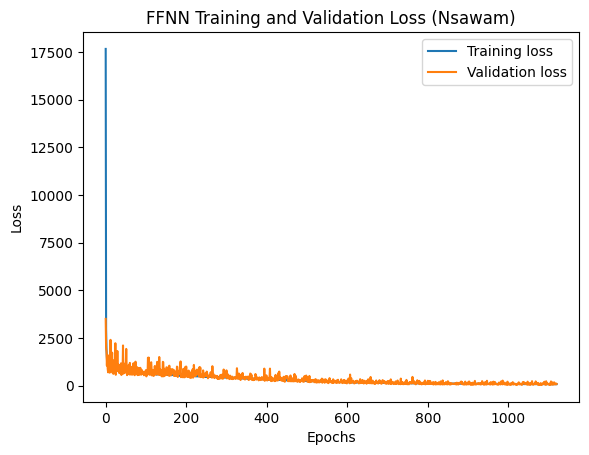

51/51 [==============================] - 0s 1ms/step


<Figure size 640x480 with 0 Axes>

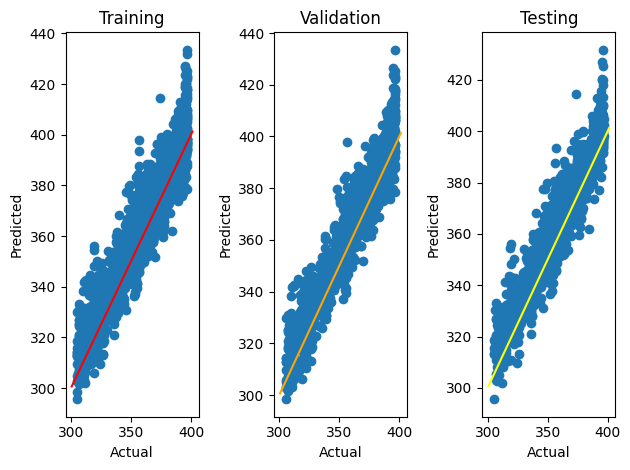

INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_ffn_saved_model\assets


INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_ffn_saved_model\assets


<Figure size 640x480 with 0 Axes>

In [ ]:
# Start MLflow run
with mlflow.start_run():

    # Log parameters
    mlflow.set_tag("programmer", "Berchie")

    mlflow.set_tag("model_type", "feedforward_neural_network")
    mlflow.set_tag("tensorflow_version", tf.__version__)
    mlflow.set_tag("experiment", "Nsawam")
    mlflow.log_param("Data-path", r"D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Nsawam.csv")
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('batch_size', batch_size)

    # Feed forward neural network model architecture
    ffn_model = Sequential()
    ffn_model.add(Input(shape=(x_train.shape[1],)))
    ffn_model.add(Dense(1000, activation='relu'))
    ffn_model.add(Dense(500, activation='relu'))
    ffn_model.add(Dense(250, activation='linear'))
    ffn_model.add(Dense(1, activation='linear'))

    # Log the model architecture using mlflow.tensorflow
    mlflow.tensorflow.log_model(ffn_model, 'nsawam_ffn_model')
    ffn_model.summary()

    # Define your model
    ffn_model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

    earlyStop = EarlyStopping(monitor='val_loss',
                            mode='min',
                            patience=patience)


    # Train the model
    history = ffn_model.fit(x_train, y_train,
                            epochs=epochs,
                            callbacks=[earlyStop],
                            batch_size=batch_size,
                            validation_data=(x_val, y_val),
                            verbose=1)

    # Log final metrics
    mlflow.log_metric("nsawam_final_training_loss", history.history['loss'][-1])
    mlflow.log_metric("nsawam_final_validation_loss", history.history['val_loss'][-1])

    # Predictions
    train_preds = ffn_model.predict(x_train)
    val_preds = ffn_model.predict(x_val)
    test_preds = ffn_model.predict(x_test)

    # Evaluation on test set
    ffn_results = ffn_model.evaluate(x_test, y_test)

    # MAE
    train_mae = mean_absolute_error(y_train, train_preds)
    val_mae = mean_absolute_error(y_val, val_preds)
    test_mae = ffn_results[1]

    # MSE
    train_mse = mean_squared_error(y_train, train_preds)
    val_mse = mean_squared_error(y_val, val_preds)
    test_mse = ffn_results[0]

    # RMSE
    train_rmse = np.sqrt(train_mse)
    val_rmse = np.sqrt(val_mse)
    test_rmse = np.sqrt(test_mse)

    # R-Square
    train_r2 = r2_score(y_train, train_preds)
    val_r2 = r2_score(y_val, val_preds)
    test_r2 = r2_score(y_test, test_preds)

    # MAPE
    train_mape = np.mean(np.abs((y_train - train_preds.flatten()) / y_train)) * 100
    val_mape = np.mean(np.abs((y_val - val_preds.flatten()) / y_val)) * 100
    test_mape = np.mean(np.abs((y_test - test_preds.flatten()) / y_test)) * 100

    # AIC calculation for the feed-forward neural network
    n_samples = len(y_train)
    log_likelihood = -0.5 * n_samples * np.log(2 * np.pi * train_mse) - 0.5 * n_samples

    # Number of parameters in the model
    n_params = sum([np.prod(w.shape) for w in ffn_model.get_weights()])

    # Calculate AIC
    aic_ffn = -2 * log_likelihood + 2 * n_params

    # Log AIC as a metric
    mlflow.log_metric("nsawam_aic_ffn", aic_ffn)

    # Logging metrics
    mlflow.log_metric("nsawam_train_mae", train_mae)
    mlflow.log_metric("nsawam_val_mae", val_mae)
    mlflow.log_metric("nsawam_test_mae", test_mae)

    mlflow.log_metric("nsawam_train_mse", train_mse)
    mlflow.log_metric("nsawam_val_mse", val_mse)
    mlflow.log_metric("nsawam_test_mse", test_mse)

    mlflow.log_metric("nsawam_train_rmse", train_rmse)
    mlflow.log_metric("nsawam_val_rmse", val_rmse)
    mlflow.log_metric("nsawam_test_rmse", test_rmse)

    mlflow.log_metric("nsawam_train_r2", train_r2)
    mlflow.log_metric("nsawam_val_r2", val_r2)
    mlflow.log_metric("nsawam_test_r2", test_r2)

    mlflow.log_metric("nsawam_train_mape", train_mape)
    mlflow.log_metric("nsawam_val_mape", val_mape)
    mlflow.log_metric("nsawam_test_mape", test_mape)

    # Plot and save training/validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('FFNN Training and Validation Loss (Nsawam)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    #Directory to save the plot
    plot_directory = "D:\\RGT\\Code\\Practice\\Deep Learning for GWL Changes\\Artifacts"
    os.makedirs(plot_directory, exist_ok=True)

    loss_plot_path = os.path.join(plot_directory, "nsawam_ffn_loss_plot.png")
    plt.savefig(loss_plot_path)
    mlflow.log_artifact(loss_plot_path)

    # Log scatter plots
    fig, axes = plt.subplots(1, 3)

    # Training Results
    axes[0].scatter(x=y_train, y=train_preds)
    axes[0].set_xlabel("Actual", fontsize=10)
    axes[0].set_ylabel("Predicted", fontsize=10)
    axes[0].set_title("Training")

    x = np.linspace(*axes[0].get_xlim())
    axes[0].plot(x, x, color='red')

    # Validation Results
    axes[1].scatter(x=y_val, y=val_preds)
    axes[1].set_xlabel("Actual", fontsize=10)
    axes[1].set_ylabel("Predicted", fontsize=10)
    axes[1].set_title("Validation")

    x = np.linspace(*axes[1].get_xlim())
    axes[1].plot(x, x, color='orange')

    # Testing Results
    test_preds = ffn_model.predict(x_test)
    axes[2].scatter(x=y_test, y=test_preds)
    axes[2].set_xlabel("Actual", fontsize=10)
    axes[2].set_ylabel("Predicted", fontsize=10)
    axes[2].set_title("Testing")

    x = np.linspace(*axes[2].get_xlim())
    axes[2].plot(x, x, color='yellow')

    # Tight layout
    fig.tight_layout()
    plt.show()

    # Save scatter plot
    scatter_plot_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_ffn_scatter_plot.png'
    plt.savefig(scatter_plot_path)
    mlflow.log_artifact(scatter_plot_path)


    # Save the model as a TensorFlow SavedModel (optional)
    saved_model_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_ffn_saved_model'
    ffn_model.save(saved_model_path)

    # Log the SavedModel as an artifact
    mlflow.log_artifact(saved_model_path)

    mlflow.end_run()


### 2. Convolutional Neural Network

In [ ]:
# Reshape data for CNN
x_train_cnn = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(x_train_cnn.shape)

x_val_cnn = x_val.reshape(x_val.shape[0], x_val.shape[1], 1)
print(x_val_cnn.shape)

x_test_cnn = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)
print(x_test_cnn.shape)

(3214, 8, 1)
(1607, 8, 1)
(1607, 8, 1)



2024/01/28 14:20:24 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmp4bux2lrf\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmp4bux2lrf\model\data\model\assets


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 6, 1000)           4000      
                                                                 
 max_pooling1d (MaxPooling1  (None, 3, 1000)           0         
 D)                                                              
                                                                 
 dense_8 (Dense)             (None, 3, 500)            500500    
                                                                 
 flatten (Flatten)           (None, 1500)              0         
                                                                 
 dense_9 (Dense)             (None, 250)               375250    
                                                                 
 dense_10 (Dense)            (None, 1)                 251       
                                                      

65/65 [==============================] - 1s 17ms/step - loss: 600.5155 - mae: 19.9547 - val_loss: 687.6246 - val_mae: 22.3245
Epoch 51/2000
65/65 [==============================] - 1s 16ms/step - loss: 604.4068 - mae: 20.0840 - val_loss: 664.5648 - val_mae: 21.8161
Epoch 52/2000
65/65 [==============================] - 1s 16ms/step - loss: 636.8329 - mae: 20.6898 - val_loss: 595.6104 - val_mae: 19.8099
Epoch 53/2000
65/65 [==============================] - 1s 16ms/step - loss: 688.9748 - mae: 21.3255 - val_loss: 629.3800 - val_mae: 21.1338
Epoch 54/2000
65/65 [==============================] - 1s 16ms/step - loss: 613.0367 - mae: 20.3630 - val_loss: 614.6379 - val_mae: 20.6106
Epoch 55/2000
65/65 [==============================] - 1s 16ms/step - loss: 646.3618 - mae: 20.6608 - val_loss: 599.2859 - val_mae: 19.9365
Epoch 56/2000
65/65 [==============================] - 1s 16ms/step - loss: 626.6095 - mae: 20.5002 - val_loss: 731.1284 - val_mae: 21.5731
Epoch 57/2000
65/65 [=============

65/65 [==============================] - 1s 16ms/step - loss: 581.8279 - mae: 19.6878 - val_loss: 632.9427 - val_mae: 20.1284
Epoch 109/2000
65/65 [==============================] - 1s 16ms/step - loss: 583.7525 - mae: 19.6962 - val_loss: 601.9016 - val_mae: 19.6115
Epoch 110/2000
65/65 [==============================] - 1s 17ms/step - loss: 605.7318 - mae: 20.1493 - val_loss: 603.5366 - val_mae: 19.6834
Epoch 111/2000
65/65 [==============================] - 1s 16ms/step - loss: 594.8503 - mae: 19.9423 - val_loss: 770.8328 - val_mae: 23.5952
Epoch 112/2000
65/65 [==============================] - 1s 16ms/step - loss: 609.9473 - mae: 20.1279 - val_loss: 611.4172 - val_mae: 20.6452
Epoch 113/2000
65/65 [==============================] - 1s 16ms/step - loss: 603.8276 - mae: 20.0029 - val_loss: 586.2776 - val_mae: 20.1166
Epoch 114/2000
65/65 [==============================] - 1s 18ms/step - loss: 609.7283 - mae: 20.0895 - val_loss: 609.0623 - val_mae: 20.6584
Epoch 115/2000
65/65 [======

65/65 [==============================] - 1s 15ms/step - loss: 578.4024 - mae: 19.5409 - val_loss: 574.2004 - val_mae: 19.8427
Epoch 167/2000
65/65 [==============================] - 1s 16ms/step - loss: 585.6256 - mae: 19.5662 - val_loss: 593.7766 - val_mae: 20.3462
Epoch 168/2000
65/65 [==============================] - 1s 15ms/step - loss: 580.0289 - mae: 19.5040 - val_loss: 567.4617 - val_mae: 19.3359
Epoch 169/2000
65/65 [==============================] - 1s 16ms/step - loss: 597.8922 - mae: 19.8692 - val_loss: 633.3466 - val_mae: 21.1717
Epoch 170/2000
65/65 [==============================] - 1s 16ms/step - loss: 564.8333 - mae: 19.3322 - val_loss: 564.9852 - val_mae: 19.4360
Epoch 171/2000
65/65 [==============================] - 1s 15ms/step - loss: 601.6693 - mae: 19.9292 - val_loss: 570.9905 - val_mae: 19.2810
Epoch 172/2000
65/65 [==============================] - 1s 15ms/step - loss: 565.5453 - mae: 19.3313 - val_loss: 565.4587 - val_mae: 19.2136
Epoch 173/2000
65/65 [======

65/65 [==============================] - 1s 16ms/step - loss: 541.5670 - mae: 18.8272 - val_loss: 581.3595 - val_mae: 19.3131
Epoch 225/2000
65/65 [==============================] - 1s 18ms/step - loss: 559.3418 - mae: 19.1759 - val_loss: 544.8181 - val_mae: 18.7501
Epoch 226/2000
65/65 [==============================] - 1s 17ms/step - loss: 547.7487 - mae: 19.0890 - val_loss: 556.2012 - val_mae: 19.4859
Epoch 227/2000
65/65 [==============================] - 1s 16ms/step - loss: 566.1088 - mae: 19.3395 - val_loss: 569.3525 - val_mae: 19.8135
Epoch 228/2000
65/65 [==============================] - 1s 16ms/step - loss: 545.0215 - mae: 18.9526 - val_loss: 532.6501 - val_mae: 18.8396
Epoch 229/2000
65/65 [==============================] - 1s 16ms/step - loss: 565.4839 - mae: 19.1844 - val_loss: 633.8589 - val_mae: 20.1409
Epoch 230/2000
65/65 [==============================] - 1s 16ms/step - loss: 573.1315 - mae: 19.4112 - val_loss: 616.8378 - val_mae: 20.7497
Epoch 231/2000
65/65 [======

65/65 [==============================] - 1s 17ms/step - loss: 540.4733 - mae: 18.8855 - val_loss: 548.4012 - val_mae: 18.7128
Epoch 283/2000
65/65 [==============================] - 1s 17ms/step - loss: 546.8848 - mae: 18.8786 - val_loss: 514.0773 - val_mae: 18.2681
Epoch 284/2000
65/65 [==============================] - 1s 17ms/step - loss: 556.9356 - mae: 19.1824 - val_loss: 507.4348 - val_mae: 18.3245
Epoch 285/2000
65/65 [==============================] - 1s 17ms/step - loss: 558.3381 - mae: 19.1759 - val_loss: 514.6284 - val_mae: 18.3981
Epoch 286/2000
65/65 [==============================] - 1s 17ms/step - loss: 550.4993 - mae: 19.0852 - val_loss: 646.7241 - val_mae: 21.1140
Epoch 287/2000
65/65 [==============================] - 1s 17ms/step - loss: 585.2932 - mae: 19.5677 - val_loss: 518.8106 - val_mae: 18.7049
Epoch 288/2000
65/65 [==============================] - 1s 17ms/step - loss: 535.8837 - mae: 18.7753 - val_loss: 517.6500 - val_mae: 18.5389
Epoch 289/2000
65/65 [======

65/65 [==============================] - 1s 19ms/step - loss: 519.2387 - mae: 18.4077 - val_loss: 500.3188 - val_mae: 18.2894
Epoch 341/2000
65/65 [==============================] - 1s 19ms/step - loss: 496.2357 - mae: 17.8854 - val_loss: 544.7784 - val_mae: 19.2166
Epoch 342/2000
65/65 [==============================] - 1s 20ms/step - loss: 531.2658 - mae: 18.4949 - val_loss: 509.3801 - val_mae: 18.4971
Epoch 343/2000
65/65 [==============================] - 1s 19ms/step - loss: 505.2631 - mae: 18.0643 - val_loss: 524.5309 - val_mae: 18.7542
Epoch 344/2000
65/65 [==============================] - 1s 19ms/step - loss: 524.4160 - mae: 18.4739 - val_loss: 611.1541 - val_mae: 19.8173
Epoch 345/2000
65/65 [==============================] - 1s 19ms/step - loss: 516.2167 - mae: 18.2809 - val_loss: 488.7882 - val_mae: 17.9858
Epoch 346/2000
65/65 [==============================] - 1s 21ms/step - loss: 506.1727 - mae: 18.2108 - val_loss: 502.6498 - val_mae: 17.9543
Epoch 347/2000
65/65 [======

65/65 [==============================] - 1s 18ms/step - loss: 489.7954 - mae: 17.7890 - val_loss: 469.0673 - val_mae: 17.5012
Epoch 399/2000
65/65 [==============================] - 1s 19ms/step - loss: 488.0795 - mae: 17.7413 - val_loss: 502.6143 - val_mae: 17.9143
Epoch 400/2000
65/65 [==============================] - 1s 18ms/step - loss: 496.9850 - mae: 17.8712 - val_loss: 526.6010 - val_mae: 18.3059
Epoch 401/2000
65/65 [==============================] - 1s 19ms/step - loss: 488.5682 - mae: 17.7689 - val_loss: 568.6343 - val_mae: 19.6725
Epoch 402/2000
65/65 [==============================] - 1s 18ms/step - loss: 528.9950 - mae: 18.4675 - val_loss: 491.6901 - val_mae: 17.6975
Epoch 403/2000
65/65 [==============================] - 1s 18ms/step - loss: 483.4244 - mae: 17.7101 - val_loss: 492.6663 - val_mae: 18.0522
Epoch 404/2000
65/65 [==============================] - 1s 18ms/step - loss: 498.9683 - mae: 17.9985 - val_loss: 476.9212 - val_mae: 17.5277
Epoch 405/2000
65/65 [======

65/65 [==============================] - 1s 19ms/step - loss: 468.5735 - mae: 17.2632 - val_loss: 451.0729 - val_mae: 16.9801
Epoch 457/2000
65/65 [==============================] - 1s 20ms/step - loss: 492.3867 - mae: 17.8588 - val_loss: 464.8185 - val_mae: 17.0843
Epoch 458/2000
65/65 [==============================] - 1s 21ms/step - loss: 468.8025 - mae: 17.3086 - val_loss: 477.4674 - val_mae: 17.3924
Epoch 459/2000
65/65 [==============================] - 1s 18ms/step - loss: 491.9726 - mae: 17.8325 - val_loss: 443.1427 - val_mae: 16.8067
Epoch 460/2000
65/65 [==============================] - 1s 18ms/step - loss: 481.4967 - mae: 17.5697 - val_loss: 455.7098 - val_mae: 17.0035
Epoch 461/2000
65/65 [==============================] - 1s 21ms/step - loss: 467.1645 - mae: 17.3050 - val_loss: 449.7492 - val_mae: 17.0840
Epoch 462/2000
65/65 [==============================] - 1s 20ms/step - loss: 460.8446 - mae: 17.2223 - val_loss: 465.0999 - val_mae: 17.2311
Epoch 463/2000
65/65 [======

65/65 [==============================] - 1s 17ms/step - loss: 432.0349 - mae: 16.5148 - val_loss: 456.9099 - val_mae: 17.0943
Epoch 515/2000
65/65 [==============================] - 1s 19ms/step - loss: 432.0428 - mae: 16.5416 - val_loss: 429.2372 - val_mae: 16.4096
Epoch 516/2000
65/65 [==============================] - 1s 17ms/step - loss: 434.5249 - mae: 16.6246 - val_loss: 451.4151 - val_mae: 17.0763
Epoch 517/2000
65/65 [==============================] - 1s 17ms/step - loss: 428.8792 - mae: 16.4886 - val_loss: 517.1356 - val_mae: 18.0993
Epoch 518/2000
65/65 [==============================] - 1s 17ms/step - loss: 475.7397 - mae: 17.4785 - val_loss: 425.9140 - val_mae: 16.5989
Epoch 519/2000
65/65 [==============================] - 1s 17ms/step - loss: 443.6259 - mae: 16.8391 - val_loss: 406.9499 - val_mae: 16.0218
Epoch 520/2000
65/65 [==============================] - 1s 17ms/step - loss: 436.7055 - mae: 16.6387 - val_loss: 551.6970 - val_mae: 19.3181
Epoch 521/2000
65/65 [======

65/65 [==============================] - 1s 18ms/step - loss: 436.7553 - mae: 16.7418 - val_loss: 482.3075 - val_mae: 17.7106
Epoch 573/2000
65/65 [==============================] - 1s 17ms/step - loss: 428.0852 - mae: 16.5007 - val_loss: 386.4175 - val_mae: 15.5733
Epoch 574/2000
65/65 [==============================] - 1s 17ms/step - loss: 421.8186 - mae: 16.3968 - val_loss: 385.0345 - val_mae: 15.5247
Epoch 575/2000
65/65 [==============================] - 1s 18ms/step - loss: 401.4815 - mae: 15.9049 - val_loss: 410.2429 - val_mae: 15.9007
Epoch 576/2000
65/65 [==============================] - 1s 17ms/step - loss: 416.5406 - mae: 16.2048 - val_loss: 387.5908 - val_mae: 15.6201
Epoch 577/2000
65/65 [==============================] - 1s 17ms/step - loss: 416.7953 - mae: 16.1792 - val_loss: 377.2039 - val_mae: 15.3478
Epoch 578/2000
65/65 [==============================] - 1s 17ms/step - loss: 399.3923 - mae: 15.8562 - val_loss: 385.3846 - val_mae: 15.5234
Epoch 579/2000
65/65 [======

65/65 [==============================] - 1s 19ms/step - loss: 377.1256 - mae: 15.3556 - val_loss: 367.0245 - val_mae: 15.0110
Epoch 631/2000
65/65 [==============================] - 1s 18ms/step - loss: 374.2196 - mae: 15.3127 - val_loss: 351.3654 - val_mae: 14.7400
Epoch 632/2000
65/65 [==============================] - 1s 18ms/step - loss: 391.5451 - mae: 15.7489 - val_loss: 359.0347 - val_mae: 14.8964
Epoch 633/2000
65/65 [==============================] - 1s 19ms/step - loss: 388.7511 - mae: 15.6104 - val_loss: 398.3832 - val_mae: 15.6914
Epoch 634/2000
65/65 [==============================] - 1s 18ms/step - loss: 377.0107 - mae: 15.3732 - val_loss: 350.7265 - val_mae: 14.8464
Epoch 635/2000
65/65 [==============================] - 1s 19ms/step - loss: 396.0000 - mae: 15.8591 - val_loss: 363.4152 - val_mae: 15.1807
Epoch 636/2000
65/65 [==============================] - 1s 19ms/step - loss: 390.3628 - mae: 15.7427 - val_loss: 376.6396 - val_mae: 15.5591
Epoch 637/2000
65/65 [======

65/65 [==============================] - 1s 18ms/step - loss: 365.1054 - mae: 15.1703 - val_loss: 332.8735 - val_mae: 14.3282
Epoch 689/2000
65/65 [==============================] - 1s 19ms/step - loss: 345.3898 - mae: 14.7147 - val_loss: 365.8293 - val_mae: 14.8739
Epoch 690/2000
65/65 [==============================] - 1s 18ms/step - loss: 360.9652 - mae: 14.9793 - val_loss: 317.0038 - val_mae: 13.8817
Epoch 691/2000
65/65 [==============================] - 1s 19ms/step - loss: 332.7133 - mae: 14.4085 - val_loss: 320.8939 - val_mae: 13.9296
Epoch 692/2000
65/65 [==============================] - 1s 18ms/step - loss: 334.4471 - mae: 14.3951 - val_loss: 320.5796 - val_mae: 13.9707
Epoch 693/2000
65/65 [==============================] - 1s 20ms/step - loss: 351.5616 - mae: 14.6794 - val_loss: 310.8307 - val_mae: 13.7928
Epoch 694/2000
65/65 [==============================] - 1s 18ms/step - loss: 343.4583 - mae: 14.6773 - val_loss: 321.6180 - val_mae: 13.9992
Epoch 695/2000
65/65 [======

65/65 [==============================] - 1s 21ms/step - loss: 316.6610 - mae: 14.0209 - val_loss: 314.8889 - val_mae: 14.0621
Epoch 747/2000
65/65 [==============================] - 1s 18ms/step - loss: 307.5793 - mae: 13.7922 - val_loss: 296.8981 - val_mae: 13.4324
Epoch 748/2000
65/65 [==============================] - 1s 18ms/step - loss: 306.9792 - mae: 13.7691 - val_loss: 304.3628 - val_mae: 13.7255
Epoch 749/2000
65/65 [==============================] - 1s 19ms/step - loss: 312.0912 - mae: 13.8841 - val_loss: 349.2433 - val_mae: 14.7906
Epoch 750/2000
65/65 [==============================] - 1s 17ms/step - loss: 340.7722 - mae: 14.5434 - val_loss: 326.7916 - val_mae: 14.0436
Epoch 751/2000
65/65 [==============================] - 1s 17ms/step - loss: 306.0295 - mae: 13.8597 - val_loss: 310.0501 - val_mae: 13.7358
Epoch 752/2000
65/65 [==============================] - 1s 17ms/step - loss: 309.6241 - mae: 13.7943 - val_loss: 325.9222 - val_mae: 14.4179
Epoch 753/2000
65/65 [======

65/65 [==============================] - 1s 16ms/step - loss: 285.9424 - mae: 13.3157 - val_loss: 336.8678 - val_mae: 14.6659
Epoch 805/2000
65/65 [==============================] - 1s 17ms/step - loss: 265.3722 - mae: 12.7124 - val_loss: 247.1030 - val_mae: 12.0956
Epoch 806/2000
65/65 [==============================] - 1s 17ms/step - loss: 273.3559 - mae: 12.9887 - val_loss: 259.8627 - val_mae: 12.6520
Epoch 807/2000
65/65 [==============================] - 1s 16ms/step - loss: 282.8852 - mae: 13.3018 - val_loss: 267.7708 - val_mae: 12.9166
Epoch 808/2000
65/65 [==============================] - 1s 17ms/step - loss: 276.0807 - mae: 13.0042 - val_loss: 260.2522 - val_mae: 12.3648
Epoch 809/2000
65/65 [==============================] - 1s 16ms/step - loss: 274.3206 - mae: 12.9472 - val_loss: 270.3516 - val_mae: 12.7888
Epoch 810/2000
65/65 [==============================] - 1s 16ms/step - loss: 269.0659 - mae: 12.8118 - val_loss: 239.5528 - val_mae: 12.0199
Epoch 811/2000
65/65 [======

65/65 [==============================] - 1s 17ms/step - loss: 249.9232 - mae: 12.3626 - val_loss: 256.1951 - val_mae: 12.4645
Epoch 863/2000
65/65 [==============================] - 1s 17ms/step - loss: 241.3372 - mae: 12.1363 - val_loss: 234.9921 - val_mae: 11.9579
Epoch 864/2000
65/65 [==============================] - 1s 16ms/step - loss: 236.8306 - mae: 11.9643 - val_loss: 233.9771 - val_mae: 11.9668
Epoch 865/2000
65/65 [==============================] - 1s 16ms/step - loss: 242.0363 - mae: 12.0932 - val_loss: 204.3434 - val_mae: 10.9970
Epoch 866/2000
65/65 [==============================] - 1s 16ms/step - loss: 261.3119 - mae: 12.6571 - val_loss: 222.2607 - val_mae: 11.6251
Epoch 867/2000
65/65 [==============================] - 1s 17ms/step - loss: 231.0079 - mae: 11.8748 - val_loss: 220.1261 - val_mae: 11.5502
Epoch 868/2000
65/65 [==============================] - 1s 16ms/step - loss: 234.5627 - mae: 11.9622 - val_loss: 232.4961 - val_mae: 11.6677
Epoch 869/2000
65/65 [======

65/65 [==============================] - 1s 16ms/step - loss: 205.8433 - mae: 11.1219 - val_loss: 185.6886 - val_mae: 10.6264
Epoch 921/2000
65/65 [==============================] - 1s 16ms/step - loss: 193.0218 - mae: 10.7468 - val_loss: 177.4680 - val_mae: 10.1419
Epoch 922/2000
65/65 [==============================] - 1s 16ms/step - loss: 200.9646 - mae: 10.9557 - val_loss: 189.3810 - val_mae: 10.5105
Epoch 923/2000
65/65 [==============================] - 1s 16ms/step - loss: 206.1691 - mae: 11.1341 - val_loss: 217.0413 - val_mae: 11.4980
Epoch 924/2000
65/65 [==============================] - 1s 17ms/step - loss: 217.6035 - mae: 11.5061 - val_loss: 239.5358 - val_mae: 12.1629
Epoch 925/2000
65/65 [==============================] - 1s 16ms/step - loss: 224.1398 - mae: 11.6402 - val_loss: 187.0761 - val_mae: 10.5326
Epoch 926/2000
65/65 [==============================] - 1s 16ms/step - loss: 216.1092 - mae: 11.5164 - val_loss: 205.8055 - val_mae: 11.4035
Epoch 927/2000
65/65 [======

65/65 [==============================] - 1s 16ms/step - loss: 191.2536 - mae: 10.7585 - val_loss: 194.9943 - val_mae: 10.6081
Epoch 979/2000
65/65 [==============================] - 1s 16ms/step - loss: 187.3063 - mae: 10.6444 - val_loss: 166.0108 - val_mae: 9.7523
Epoch 980/2000
65/65 [==============================] - 1s 17ms/step - loss: 180.2388 - mae: 10.4137 - val_loss: 152.2633 - val_mae: 9.4399
Epoch 981/2000
65/65 [==============================] - 1s 16ms/step - loss: 173.8653 - mae: 10.2636 - val_loss: 176.9911 - val_mae: 10.3058
Epoch 982/2000
65/65 [==============================] - 1s 16ms/step - loss: 167.0623 - mae: 9.9566 - val_loss: 205.8505 - val_mae: 11.4891
Epoch 983/2000
65/65 [==============================] - 1s 16ms/step - loss: 181.9552 - mae: 10.4620 - val_loss: 176.9496 - val_mae: 10.4529
Epoch 984/2000
65/65 [==============================] - 1s 16ms/step - loss: 173.4530 - mae: 10.1763 - val_loss: 154.9217 - val_mae: 9.5442
Epoch 985/2000
65/65 [==========

65/65 [==============================] - 1s 20ms/step - loss: 148.6620 - mae: 9.3822 - val_loss: 169.7976 - val_mae: 10.2223
Epoch 1037/2000
65/65 [==============================] - 1s 20ms/step - loss: 144.8001 - mae: 9.2162 - val_loss: 142.9039 - val_mae: 9.1770
Epoch 1038/2000
65/65 [==============================] - 1s 19ms/step - loss: 137.2351 - mae: 9.0119 - val_loss: 119.2895 - val_mae: 8.3240
Epoch 1039/2000
65/65 [==============================] - 1s 20ms/step - loss: 139.4440 - mae: 9.0227 - val_loss: 156.9626 - val_mae: 9.8491
Epoch 1040/2000
65/65 [==============================] - 1s 20ms/step - loss: 137.0196 - mae: 8.9514 - val_loss: 120.0757 - val_mae: 8.3141
Epoch 1041/2000
65/65 [==============================] - 1s 22ms/step - loss: 137.8771 - mae: 9.0625 - val_loss: 124.5320 - val_mae: 8.6413
Epoch 1042/2000
65/65 [==============================] - 1s 22ms/step - loss: 143.1418 - mae: 9.1954 - val_loss: 147.0520 - val_mae: 9.3168
Epoch 1043/2000
65/65 [============

65/65 [==============================] - 1s 21ms/step - loss: 117.3308 - mae: 8.3522 - val_loss: 101.1536 - val_mae: 7.6454
Epoch 1095/2000
65/65 [==============================] - 1s 20ms/step - loss: 114.2057 - mae: 8.2298 - val_loss: 112.7181 - val_mae: 8.2639
Epoch 1096/2000
65/65 [==============================] - 1s 19ms/step - loss: 112.6900 - mae: 8.1138 - val_loss: 91.9869 - val_mae: 7.2057
Epoch 1097/2000
65/65 [==============================] - 1s 20ms/step - loss: 105.3403 - mae: 7.7809 - val_loss: 101.3886 - val_mae: 7.6319
Epoch 1098/2000
65/65 [==============================] - 1s 20ms/step - loss: 107.0415 - mae: 7.8930 - val_loss: 97.6189 - val_mae: 7.5763
Epoch 1099/2000
65/65 [==============================] - 1s 19ms/step - loss: 109.5838 - mae: 7.9700 - val_loss: 91.9671 - val_mae: 7.2497
Epoch 1100/2000
65/65 [==============================] - 1s 20ms/step - loss: 113.5835 - mae: 8.1274 - val_loss: 120.4569 - val_mae: 8.6009
Epoch 1101/2000
65/65 [================

65/65 [==============================] - 1s 17ms/step - loss: 78.6077 - mae: 6.6318 - val_loss: 69.0553 - val_mae: 6.1624
Epoch 1154/2000
65/65 [==============================] - 1s 17ms/step - loss: 83.0485 - mae: 6.9816 - val_loss: 73.5218 - val_mae: 6.5278
Epoch 1155/2000
65/65 [==============================] - 1s 17ms/step - loss: 84.2020 - mae: 7.0150 - val_loss: 74.4866 - val_mae: 6.5850
Epoch 1156/2000
65/65 [==============================] - 1s 19ms/step - loss: 83.8011 - mae: 6.9923 - val_loss: 84.5692 - val_mae: 7.0762
Epoch 1157/2000
65/65 [==============================] - 1s 17ms/step - loss: 83.4140 - mae: 6.9678 - val_loss: 89.6827 - val_mae: 7.2553
Epoch 1158/2000
65/65 [==============================] - 1s 17ms/step - loss: 102.6468 - mae: 7.9172 - val_loss: 99.0742 - val_mae: 7.7319
Epoch 1159/2000
65/65 [==============================] - 1s 18ms/step - loss: 90.6182 - mae: 7.3441 - val_loss: 74.1025 - val_mae: 6.6056
Epoch 1160/2000
65/65 [==========================

65/65 [==============================] - 1s 17ms/step - loss: 67.2636 - mae: 6.2984 - val_loss: 62.3746 - val_mae: 6.2363
Epoch 1213/2000
65/65 [==============================] - 1s 17ms/step - loss: 62.5858 - mae: 6.0477 - val_loss: 52.6213 - val_mae: 5.6101
Epoch 1214/2000
65/65 [==============================] - 1s 17ms/step - loss: 65.4057 - mae: 6.1697 - val_loss: 58.3063 - val_mae: 5.8894
Epoch 1215/2000
65/65 [==============================] - 1s 17ms/step - loss: 73.8786 - mae: 6.6154 - val_loss: 60.4818 - val_mae: 5.9383
Epoch 1216/2000
65/65 [==============================] - 1s 17ms/step - loss: 67.1201 - mae: 6.2505 - val_loss: 59.2610 - val_mae: 5.8348
Epoch 1217/2000
65/65 [==============================] - 1s 17ms/step - loss: 80.3151 - mae: 6.9311 - val_loss: 63.5696 - val_mae: 6.1846
Epoch 1218/2000
65/65 [==============================] - 1s 17ms/step - loss: 67.6789 - mae: 6.3306 - val_loss: 78.6268 - val_mae: 6.8783
Epoch 1219/2000
65/65 [===========================

65/65 [==============================] - 1s 17ms/step - loss: 67.6397 - mae: 6.4492 - val_loss: 51.7606 - val_mae: 5.6249
Epoch 1272/2000
65/65 [==============================] - 1s 17ms/step - loss: 59.3351 - mae: 6.0102 - val_loss: 43.5349 - val_mae: 5.0527
Epoch 1273/2000
65/65 [==============================] - 1s 17ms/step - loss: 56.9794 - mae: 5.8543 - val_loss: 73.0015 - val_mae: 6.9910
Epoch 1274/2000
65/65 [==============================] - 1s 17ms/step - loss: 56.9347 - mae: 5.8160 - val_loss: 43.0002 - val_mae: 5.1133
Epoch 1275/2000
65/65 [==============================] - 1s 17ms/step - loss: 44.9540 - mae: 5.0766 - val_loss: 40.0064 - val_mae: 4.8540
Epoch 1276/2000
65/65 [==============================] - 1s 17ms/step - loss: 53.4103 - mae: 5.5733 - val_loss: 54.3693 - val_mae: 5.7266
Epoch 1277/2000
65/65 [==============================] - 1s 17ms/step - loss: 52.0710 - mae: 5.5177 - val_loss: 47.7029 - val_mae: 5.3966
Epoch 1278/2000
65/65 [===========================

65/65 [==============================] - 1s 17ms/step - loss: 46.4884 - mae: 5.2547 - val_loss: 43.8249 - val_mae: 5.2393
Epoch 1331/2000
65/65 [==============================] - 1s 17ms/step - loss: 49.5872 - mae: 5.5066 - val_loss: 36.1809 - val_mae: 4.6740
Epoch 1332/2000
65/65 [==============================] - 1s 17ms/step - loss: 40.8195 - mae: 4.9018 - val_loss: 38.6687 - val_mae: 4.8379
Epoch 1333/2000
65/65 [==============================] - 1s 17ms/step - loss: 42.7710 - mae: 5.0537 - val_loss: 32.9744 - val_mae: 4.4121
Epoch 1334/2000
65/65 [==============================] - 1s 17ms/step - loss: 43.0854 - mae: 5.0695 - val_loss: 46.9256 - val_mae: 5.2823
Epoch 1335/2000
65/65 [==============================] - 1s 17ms/step - loss: 40.6462 - mae: 4.8620 - val_loss: 62.4315 - val_mae: 6.4336
Epoch 1336/2000
65/65 [==============================] - 1s 17ms/step - loss: 49.8972 - mae: 5.5227 - val_loss: 64.6720 - val_mae: 6.4454
Epoch 1337/2000
65/65 [===========================

65/65 [==============================] - 1s 20ms/step - loss: 34.8941 - mae: 4.5971 - val_loss: 30.8656 - val_mae: 4.3749
Epoch 1390/2000
65/65 [==============================] - 1s 21ms/step - loss: 39.3409 - mae: 4.8806 - val_loss: 43.1508 - val_mae: 5.2190
Epoch 1391/2000
65/65 [==============================] - 1s 20ms/step - loss: 42.0795 - mae: 5.0139 - val_loss: 39.4616 - val_mae: 4.9063
Epoch 1392/2000
65/65 [==============================] - 1s 21ms/step - loss: 35.2252 - mae: 4.5922 - val_loss: 33.4023 - val_mae: 4.5815
Epoch 1393/2000
65/65 [==============================] - 1s 20ms/step - loss: 32.7418 - mae: 4.4386 - val_loss: 22.3681 - val_mae: 3.6431
Epoch 1394/2000
65/65 [==============================] - 1s 21ms/step - loss: 31.1703 - mae: 4.2721 - val_loss: 40.2790 - val_mae: 5.0027
Epoch 1395/2000
65/65 [==============================] - 1s 19ms/step - loss: 40.4108 - mae: 4.9311 - val_loss: 57.4815 - val_mae: 6.1382
Epoch 1396/2000
65/65 [===========================

65/65 [==============================] - 1s 19ms/step - loss: 25.0846 - mae: 3.8682 - val_loss: 24.7320 - val_mae: 3.9289
Epoch 1449/2000
65/65 [==============================] - 1s 18ms/step - loss: 26.1927 - mae: 3.9706 - val_loss: 20.5997 - val_mae: 3.4227
Epoch 1450/2000
65/65 [==============================] - 1s 18ms/step - loss: 24.3946 - mae: 3.7956 - val_loss: 30.3844 - val_mae: 4.3711
Epoch 1451/2000
65/65 [==============================] - 1s 18ms/step - loss: 23.2941 - mae: 3.7217 - val_loss: 18.6285 - val_mae: 3.3339
Epoch 1452/2000
65/65 [==============================] - 1s 18ms/step - loss: 23.4475 - mae: 3.7420 - val_loss: 27.4161 - val_mae: 4.0051
Epoch 1453/2000
65/65 [==============================] - 1s 18ms/step - loss: 30.3375 - mae: 4.2538 - val_loss: 34.4194 - val_mae: 4.6702
Epoch 1454/2000
65/65 [==============================] - 1s 18ms/step - loss: 28.4421 - mae: 4.1286 - val_loss: 31.4783 - val_mae: 4.4873
Epoch 1455/2000
65/65 [===========================

65/65 [==============================] - 1s 17ms/step - loss: 22.7420 - mae: 3.7145 - val_loss: 19.0579 - val_mae: 3.4191
Epoch 1508/2000
65/65 [==============================] - 1s 17ms/step - loss: 16.2907 - mae: 3.0350 - val_loss: 16.1410 - val_mae: 3.0988
Epoch 1509/2000
65/65 [==============================] - 1s 17ms/step - loss: 17.2637 - mae: 3.1959 - val_loss: 19.3748 - val_mae: 3.4304
Epoch 1510/2000
65/65 [==============================] - 1s 17ms/step - loss: 20.1642 - mae: 3.4485 - val_loss: 39.6420 - val_mae: 4.9286
Epoch 1511/2000
65/65 [==============================] - 1s 17ms/step - loss: 27.5753 - mae: 4.0888 - val_loss: 31.2885 - val_mae: 4.4787
Epoch 1512/2000
65/65 [==============================] - 1s 17ms/step - loss: 22.4411 - mae: 3.6393 - val_loss: 15.0539 - val_mae: 3.0211
Epoch 1513/2000
65/65 [==============================] - 1s 17ms/step - loss: 18.8603 - mae: 3.3670 - val_loss: 14.7885 - val_mae: 2.9021
Epoch 1514/2000
65/65 [===========================

65/65 [==============================] - 1s 17ms/step - loss: 22.3428 - mae: 3.6609 - val_loss: 21.1553 - val_mae: 3.6616
Epoch 1567/2000
65/65 [==============================] - 1s 17ms/step - loss: 23.2668 - mae: 3.7603 - val_loss: 13.9618 - val_mae: 2.9390
Epoch 1568/2000
65/65 [==============================] - 1s 17ms/step - loss: 21.9230 - mae: 3.6404 - val_loss: 36.7272 - val_mae: 4.8021
Epoch 1569/2000
65/65 [==============================] - 1s 17ms/step - loss: 24.3111 - mae: 3.8772 - val_loss: 16.1000 - val_mae: 3.1485
Epoch 1570/2000
65/65 [==============================] - 1s 17ms/step - loss: 20.4281 - mae: 3.5502 - val_loss: 17.2595 - val_mae: 3.1128
Epoch 1571/2000
65/65 [==============================] - 1s 17ms/step - loss: 16.4758 - mae: 3.1456 - val_loss: 14.3463 - val_mae: 2.9377
Epoch 1572/2000
65/65 [==============================] - 1s 17ms/step - loss: 15.1457 - mae: 3.0112 - val_loss: 17.2774 - val_mae: 3.1563
Epoch 1573/2000
65/65 [===========================

65/65 [==============================] - 1s 16ms/step - loss: 17.4634 - mae: 3.2614 - val_loss: 15.1897 - val_mae: 3.0541
Epoch 1626/2000
65/65 [==============================] - 1s 17ms/step - loss: 15.8188 - mae: 3.1128 - val_loss: 15.0255 - val_mae: 3.0820
Epoch 1627/2000
65/65 [==============================] - 1s 17ms/step - loss: 12.5912 - mae: 2.7878 - val_loss: 9.9565 - val_mae: 2.4121
Epoch 1628/2000
65/65 [==============================] - 1s 17ms/step - loss: 12.2095 - mae: 2.7277 - val_loss: 10.7272 - val_mae: 2.5335
Epoch 1629/2000
65/65 [==============================] - 1s 17ms/step - loss: 13.7922 - mae: 2.8561 - val_loss: 12.3055 - val_mae: 2.7827
Epoch 1630/2000
65/65 [==============================] - 1s 16ms/step - loss: 16.4413 - mae: 3.1405 - val_loss: 12.3147 - val_mae: 2.7328
Epoch 1631/2000
65/65 [==============================] - 1s 17ms/step - loss: 17.2861 - mae: 3.2643 - val_loss: 20.3022 - val_mae: 3.6176
Epoch 1632/2000
65/65 [============================

65/65 [==============================] - 1s 17ms/step - loss: 16.5142 - mae: 3.2326 - val_loss: 12.7586 - val_mae: 2.7897
Epoch 1685/2000
65/65 [==============================] - 1s 16ms/step - loss: 15.4312 - mae: 3.0936 - val_loss: 18.4443 - val_mae: 3.3675
Epoch 1686/2000
65/65 [==============================] - 1s 17ms/step - loss: 15.5466 - mae: 3.0304 - val_loss: 25.0597 - val_mae: 3.9478
Epoch 1687/2000
65/65 [==============================] - 1s 17ms/step - loss: 35.9270 - mae: 4.6718 - val_loss: 16.6830 - val_mae: 3.1470
Epoch 1688/2000
65/65 [==============================] - 1s 17ms/step - loss: 16.3705 - mae: 3.1028 - val_loss: 13.7771 - val_mae: 2.8953
Epoch 1689/2000
65/65 [==============================] - 1s 17ms/step - loss: 24.4685 - mae: 3.8207 - val_loss: 24.6823 - val_mae: 3.9106
Epoch 1690/2000
65/65 [==============================] - 1s 17ms/step - loss: 23.1864 - mae: 3.7443 - val_loss: 12.7608 - val_mae: 2.7918
Epoch 1691/2000
65/65 [===========================

65/65 [==============================] - 1s 17ms/step - loss: 10.4774 - mae: 2.5377 - val_loss: 9.6214 - val_mae: 2.4902
Epoch 1744/2000
65/65 [==============================] - 1s 17ms/step - loss: 9.2110 - mae: 2.3555 - val_loss: 8.4382 - val_mae: 2.2573
Epoch 1745/2000
65/65 [==============================] - 1s 17ms/step - loss: 8.4884 - mae: 2.2857 - val_loss: 6.1588 - val_mae: 1.9559
Epoch 1746/2000
65/65 [==============================] - 1s 17ms/step - loss: 6.9147 - mae: 2.0325 - val_loss: 8.8562 - val_mae: 2.3421
Epoch 1747/2000
65/65 [==============================] - 1s 17ms/step - loss: 7.9497 - mae: 2.1925 - val_loss: 7.0073 - val_mae: 2.0985
Epoch 1748/2000
65/65 [==============================] - 1s 16ms/step - loss: 14.4579 - mae: 2.9549 - val_loss: 16.2253 - val_mae: 3.1698
Epoch 1749/2000
65/65 [==============================] - 1s 17ms/step - loss: 14.6007 - mae: 2.9791 - val_loss: 10.1891 - val_mae: 2.4775
Epoch 1750/2000
65/65 [==============================] - 1s

Epoch 1803/2000
65/65 [==============================] - 1s 17ms/step - loss: 21.7472 - mae: 3.6812 - val_loss: 13.8233 - val_mae: 2.8747
Epoch 1804/2000
65/65 [==============================] - 1s 17ms/step - loss: 13.7036 - mae: 2.8729 - val_loss: 11.0756 - val_mae: 2.6526
Epoch 1805/2000
65/65 [==============================] - 1s 17ms/step - loss: 14.3342 - mae: 2.9607 - val_loss: 16.0467 - val_mae: 3.2062
Epoch 1806/2000
65/65 [==============================] - 1s 16ms/step - loss: 15.7427 - mae: 3.0988 - val_loss: 12.7742 - val_mae: 2.7627
Epoch 1807/2000
65/65 [==============================] - 1s 17ms/step - loss: 13.7422 - mae: 2.8907 - val_loss: 16.3623 - val_mae: 3.1608
Epoch 1808/2000
65/65 [==============================] - 1s 17ms/step - loss: 12.9392 - mae: 2.7843 - val_loss: 30.5330 - val_mae: 4.5889
Epoch 1809/2000
65/65 [==============================] - 1s 17ms/step - loss: 16.5230 - mae: 3.1772 - val_loss: 21.5731 - val_mae: 3.5816
Epoch 1810/2000
65/65 [===========

65/65 [==============================] - 1s 17ms/step - loss: 21.9273 - mae: 3.6716 - val_loss: 15.4574 - val_mae: 3.0218
Epoch 1863/2000
65/65 [==============================] - 1s 17ms/step - loss: 19.5549 - mae: 3.3910 - val_loss: 15.8361 - val_mae: 3.0100
Epoch 1864/2000
65/65 [==============================] - 1s 17ms/step - loss: 10.0630 - mae: 2.4609 - val_loss: 9.0647 - val_mae: 2.4218
Epoch 1865/2000
65/65 [==============================] - 1s 17ms/step - loss: 10.7401 - mae: 2.5938 - val_loss: 15.9769 - val_mae: 3.2145
Epoch 1866/2000
65/65 [==============================] - 1s 17ms/step - loss: 11.5533 - mae: 2.6743 - val_loss: 9.8782 - val_mae: 2.5129
Epoch 1867/2000
65/65 [==============================] - 1s 17ms/step - loss: 8.3189 - mae: 2.2804 - val_loss: 6.9533 - val_mae: 2.0586
Epoch 1868/2000
65/65 [==============================] - 1s 17ms/step - loss: 11.2825 - mae: 2.6714 - val_loss: 10.2284 - val_mae: 2.5113
Epoch 1869/2000
65/65 [==============================]

Epoch 1922/2000
65/65 [==============================] - 1s 17ms/step - loss: 8.6286 - mae: 2.2782 - val_loss: 5.5615 - val_mae: 1.8713
Epoch 1923/2000
65/65 [==============================] - 1s 17ms/step - loss: 6.3366 - mae: 1.9823 - val_loss: 6.1298 - val_mae: 1.9299
Epoch 1924/2000
65/65 [==============================] - 1s 17ms/step - loss: 5.8281 - mae: 1.8799 - val_loss: 7.2449 - val_mae: 2.1763
Epoch 1925/2000
65/65 [==============================] - 1s 17ms/step - loss: 9.4681 - mae: 2.3999 - val_loss: 13.8547 - val_mae: 3.0326
Epoch 1926/2000
65/65 [==============================] - 1s 17ms/step - loss: 11.2546 - mae: 2.6276 - val_loss: 11.8434 - val_mae: 2.7593
Epoch 1927/2000
65/65 [==============================] - 1s 17ms/step - loss: 15.3637 - mae: 3.0501 - val_loss: 14.1090 - val_mae: 2.9366
Epoch 1928/2000
65/65 [==============================] - 1s 17ms/step - loss: 22.2047 - mae: 3.7090 - val_loss: 17.3385 - val_mae: 3.3193
Epoch 1929/2000
65/65 [==================

OSError: [Errno 22] Invalid argument: 'D:\\RGT\\Code\\Practice\\Deep Learning for GWL Changes\\Artifacts\nsawam_cnn_loss_plot.png'

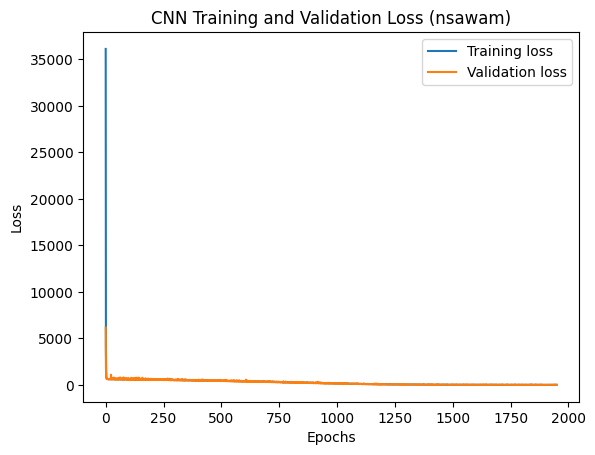

In [ ]:
# Start MLflow run
with mlflow.start_run():

    # Log parameters
    mlflow.set_tag("programmer", "Berchie")
    mlflow.set_tag("model_type", "convolutional_neural_network")
    mlflow.set_tag("tensorflow_version", tf.__version__)
    mlflow.set_tag("experiment", "Nsawam")
    mlflow.log_param("Data-path", r"D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Nsawam.csv")
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('batch_size', batch_size)

    #Convolutional neural network model architecture
    cnn_model = Sequential()
    cnn_model.add(Conv1D(1000, 3, activation="relu", input_shape=(x_train.shape[1], 1)))
    cnn_model.add(MaxPooling1D(pool_size=2))
    cnn_model.add(Dense(500, activation='relu'))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(250, activation='relu'))
    cnn_model.add(Dense(1, activation='linear'))

    # Log the model architecture using mlflow.tensorflow
    mlflow.tensorflow.log_model(cnn_model, 'cnn_model')

    cnn_model.summary()

    cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    earlyStop = EarlyStopping(monitor='val_loss',
                             mode='min',
                             patience=patience)

    history = cnn_model.fit(x_train_cnn, y_train,
              		    epochs=epochs,
               		    callbacks=[earlyStop],
               		    batch_size=batch_size,
               		    validation_data=(x_val_cnn, y_val),
               		    verbose=1)
    # Log metrics
    mlflow.log_metric('nsawam_final_training_loss', history.history['loss'][-1])
    mlflow.log_metric('nsawam_final_validation_loss', history.history['val_loss'][-1])

    # Predictions
    train_preds = cnn_model.predict(x_train_cnn)
    val_preds = cnn_model.predict(x_val_cnn)
    test_preds = cnn_model.predict(x_test_cnn)

    # Evaluate on test set
    cnn_results = cnn_model.evaluate(x_test_cnn, y_test)

    # Mean Absolute Error (MAE)
    cnn_train_mae = mean_absolute_error(y_train, train_preds)
    cnn_val_mae = mean_absolute_error(y_val, val_preds)
    cnn_test_mae = cnn_results[1]

    # Mean Square Error (MAE)
    cnn_train_mse = mean_squared_error(y_train, train_preds)
    cnn_val_mse = mean_squared_error(y_val, val_preds)
    cnn_test_mse = cnn_results[0]

    # Root Mean Squared Error
    cnn_train_rmse = np.sqrt(cnn_train_mse)
    cnn_val_rmse = np.sqrt(cnn_val_mse)
    cnn_test_rmse = np.sqrt(cnn_test_mse)

    # R-Squared
    cnn_train_r2 = r2_score(y_train, train_preds)
    cnn_val_r2 = r2_score(y_val, val_preds)
    cnn_test_r2 = r2_score(y_test, test_preds)

    # Mean Absolute Percentage Error
    cnn_train_mape = np.mean(np.abs((y_train - train_preds.flatten()) / y_train)) * 100
    cnn_val_mape = np.mean(np.abs((y_val - val_preds.flatten()) / y_val)) * 100
    cnn_test_mape = np.mean(np.abs((y_test - test_preds.flatten()) / y_test)) * 100

    # AIC calculation for the CNN
    n_samples_cnn = len(y_train)
    log_likelihood_cnn = -0.5 * n_samples_cnn * np.log(2 * np.pi * cnn_train_mse) - 0.5 * n_samples_cnn
    n_params_cnn = sum([np.prod(w.shape) for w in cnn_model.get_weights()])
    aic_cnn = -2 * log_likelihood_cnn + 2 * n_params_cnn

    # Log AIC as a metric
    mlflow.log_metric("nsawam_aic_cnn", aic_cnn)

    # Logging metrics
    mlflow.log_metric('nsawam_cnn_train_mae', cnn_train_mae)
    mlflow.log_metric('nsawam_cnn_val_mae', cnn_val_mae)
    mlflow.log_metric('nsawam_cnn_test_mae', cnn_test_mae)

    mlflow.log_metric('nsawam_cnn_train_mse', cnn_train_mse)
    mlflow.log_metric('nsawam_cnn_val_mse', cnn_val_mse)
    mlflow.log_metric('nsawam_cnn_test_mse', cnn_test_mse)

    mlflow.log_metric("nsawam_cnn_train_rmse", cnn_train_rmse)
    mlflow.log_metric("nsawam_cnn_val_rmse", cnn_val_rmse)
    mlflow.log_metric("nsawam_cnn_test_rmse", cnn_test_rmse)

    mlflow.log_metric("nsawam_cnn_train_r2", cnn_train_r2)
    mlflow.log_metric("nsawam_cnn_val_r2", cnn_val_r2)
    mlflow.log_metric("nsawam_cnn_test_r2", cnn_test_r2)

    mlflow.log_metric("nsawam_cnn_train_mape", cnn_train_mape)
    mlflow.log_metric("nsawam_cnn_val_mape", cnn_val_mape)
    mlflow.log_metric("nsawam_cnn_test_mape", cnn_test_mape)

    # Plot and save training/validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('CNN Training and Validation Loss (nsawam)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    loss_plot_path = 'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_cnn_loss_plot.png'
    plt.savefig(loss_plot_path)
    mlflow.log_artifact(loss_plot_path)

    # Log scatter plots
    fig, axes = plt.subplots(1, 3)

    # Training Results
    axes[0].scatter(x=y_train, y=train_preds)
    axes[0].set_xlabel("Actual", fontsize=10)
    axes[0].set_ylabel("Predicted", fontsize=10)
    axes[0].set_title("Training")

    x = np.linspace(*axes[0].get_xlim())
    axes[0].plot(x, x, color='red')

    # Validation Results
    axes[1].scatter(x=y_val, y=val_preds)
    axes[1].set_xlabel("Actual", fontsize=10)
    axes[1].set_ylabel("Predicted", fontsize=10)
    axes[1].set_title("Validation")

    x = np.linspace(*axes[1].get_xlim())
    axes[1].plot(x, x, color='orange')

    # Testing Results
    test_preds = ffn_model.predict(x_test)
    axes[2].scatter(x=y_test, y=test_preds)
    axes[2].set_xlabel("Actual", fontsize=10)
    axes[2].set_ylabel("Predicted", fontsize=10)
    axes[2].set_title("Testing")

    x = np.linspace(*axes[2].get_xlim())
    axes[2].plot(x, x, color='yellow')

    # Tight layout
    fig.tight_layout()

    plt.show()

    # Save scatter plot
    scatter_plot_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_cnn_scatter_plot.png'
    plt.savefig(scatter_plot_path)
    mlflow.log_artifact(scatter_plot_path)


    # Save the model as a TensorFlow SavedModel (optional)
    saved_model_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_cnn_saved_model'
    cnn_model.save(saved_model_path)

    # Log the SavedModel as an artifact
    mlflow.log_artifact(saved_model_path)

    # End the MLflow run
    mlflow.end_run()

### 3. Long Short-Term Memory RNN

2024/01/28 16:07:06 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmpuu2ft0z5\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\SAMBER~1\AppData\Local\Temp\tmpuu2ft0z5\model\data\model\assets


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000)              4008000   
                                                                 
 dense_11 (Dense)            (None, 500)               500500    
                                                                 
 dense_12 (Dense)            (None, 250)               125250    
                                                                 
 dense_13 (Dense)            (None, 1)                 251       
                                                                 
Total params: 4634001 (17.68 MB)
Trainable params: 4634001 (17.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/2000
65/65 [==============================] - 12s 152ms/step - loss: 46840.6055 - mae: 169.5171 - val_loss: 2315.0688 - val_mae: 37.0226
E

Epoch 52/2000
65/65 [==============================] - 10s 156ms/step - loss: 609.1458 - mae: 20.0358 - val_loss: 618.9917 - val_mae: 19.8632
Epoch 53/2000
65/65 [==============================] - 10s 154ms/step - loss: 614.3336 - mae: 20.2466 - val_loss: 642.1412 - val_mae: 20.1568
Epoch 54/2000
65/65 [==============================] - 10s 156ms/step - loss: 602.7509 - mae: 19.9501 - val_loss: 605.1384 - val_mae: 20.2610
Epoch 55/2000
65/65 [==============================] - 11s 167ms/step - loss: 643.3228 - mae: 20.6308 - val_loss: 599.2441 - val_mae: 19.7220
Epoch 56/2000
65/65 [==============================] - 10s 157ms/step - loss: 617.6805 - mae: 20.2052 - val_loss: 605.2343 - val_mae: 19.7333
Epoch 57/2000
65/65 [==============================] - 10s 156ms/step - loss: 594.8510 - mae: 19.7647 - val_loss: 631.4048 - val_mae: 21.0251
Epoch 58/2000
65/65 [==============================] - 10s 157ms/step - loss: 594.2260 - mae: 19.7911 - val_loss: 650.0167 - val_mae: 20.1842
Epoch 

65/65 [==============================] - 11s 169ms/step - loss: 607.3589 - mae: 20.0694 - val_loss: 719.3647 - val_mae: 22.7592
Epoch 110/2000
65/65 [==============================] - 12s 184ms/step - loss: 614.0397 - mae: 20.1109 - val_loss: 706.7573 - val_mae: 21.0223
Epoch 111/2000
65/65 [==============================] - 12s 192ms/step - loss: 645.9022 - mae: 20.6910 - val_loss: 610.4401 - val_mae: 19.5483
Epoch 112/2000
65/65 [==============================] - 13s 203ms/step - loss: 608.7307 - mae: 19.9910 - val_loss: 585.7065 - val_mae: 19.9516
Epoch 113/2000
65/65 [==============================] - 12s 185ms/step - loss: 577.2183 - mae: 19.5681 - val_loss: 625.8848 - val_mae: 19.8694
Epoch 114/2000
65/65 [==============================] - 11s 166ms/step - loss: 579.3586 - mae: 19.5616 - val_loss: 578.0403 - val_mae: 19.2474
Epoch 115/2000
65/65 [==============================] - 11s 164ms/step - loss: 578.6352 - mae: 19.4980 - val_loss: 732.5712 - val_mae: 21.2505
Epoch 116/2000

Epoch 167/2000
65/65 [==============================] - 8s 129ms/step - loss: 542.2565 - mae: 18.8870 - val_loss: 543.8643 - val_mae: 18.8177
Epoch 168/2000
65/65 [==============================] - 8s 129ms/step - loss: 577.9025 - mae: 19.5283 - val_loss: 545.6194 - val_mae: 18.9662
Epoch 169/2000
65/65 [==============================] - 8s 128ms/step - loss: 565.6882 - mae: 19.2640 - val_loss: 552.6019 - val_mae: 18.8270
Epoch 170/2000
65/65 [==============================] - 8s 128ms/step - loss: 560.4363 - mae: 19.1530 - val_loss: 561.6677 - val_mae: 18.9281
Epoch 171/2000
65/65 [==============================] - 8s 128ms/step - loss: 561.1940 - mae: 19.1860 - val_loss: 616.6105 - val_mae: 20.7714
Epoch 172/2000
65/65 [==============================] - 9s 131ms/step - loss: 597.8259 - mae: 19.8248 - val_loss: 567.6505 - val_mae: 19.1068
Epoch 173/2000
65/65 [==============================] - 9s 132ms/step - loss: 563.8508 - mae: 19.3558 - val_loss: 673.8674 - val_mae: 21.7185
Epoch 

Epoch 225/2000
65/65 [==============================] - 9s 133ms/step - loss: 478.0647 - mae: 17.6037 - val_loss: 499.5830 - val_mae: 18.0761
Epoch 226/2000
65/65 [==============================] - 9s 133ms/step - loss: 485.4196 - mae: 17.7714 - val_loss: 477.2245 - val_mae: 17.5474
Epoch 227/2000
65/65 [==============================] - 9s 132ms/step - loss: 484.4740 - mae: 17.6736 - val_loss: 466.8842 - val_mae: 17.3622
Epoch 228/2000
65/65 [==============================] - 9s 135ms/step - loss: 474.2644 - mae: 17.5468 - val_loss: 465.7152 - val_mae: 17.2455
Epoch 229/2000
65/65 [==============================] - 9s 137ms/step - loss: 487.2151 - mae: 17.7053 - val_loss: 486.4732 - val_mae: 17.9203
Epoch 230/2000
65/65 [==============================] - 9s 137ms/step - loss: 474.1459 - mae: 17.5803 - val_loss: 515.3318 - val_mae: 17.9008
Epoch 231/2000
65/65 [==============================] - 9s 137ms/step - loss: 471.2592 - mae: 17.4745 - val_loss: 461.9592 - val_mae: 17.1558
Epoch 

Epoch 283/2000
65/65 [==============================] - 9s 139ms/step - loss: 334.9760 - mae: 14.2613 - val_loss: 430.7036 - val_mae: 16.9006
Epoch 284/2000
65/65 [==============================] - 9s 134ms/step - loss: 350.1529 - mae: 14.5911 - val_loss: 323.2231 - val_mae: 14.1222
Epoch 285/2000
65/65 [==============================] - 9s 133ms/step - loss: 330.5199 - mae: 14.1920 - val_loss: 325.5556 - val_mae: 14.2944
Epoch 286/2000
65/65 [==============================] - 9s 134ms/step - loss: 345.0068 - mae: 14.4772 - val_loss: 299.8031 - val_mae: 13.4912
Epoch 287/2000
65/65 [==============================] - 9s 134ms/step - loss: 342.0853 - mae: 14.4366 - val_loss: 389.1139 - val_mae: 15.9737
Epoch 288/2000
65/65 [==============================] - 9s 133ms/step - loss: 338.9300 - mae: 14.4706 - val_loss: 388.6205 - val_mae: 15.3635
Epoch 289/2000
65/65 [==============================] - 9s 131ms/step - loss: 312.1355 - mae: 13.6227 - val_loss: 316.5191 - val_mae: 14.0216
Epoch 

Epoch 341/2000
65/65 [==============================] - 9s 135ms/step - loss: 118.6357 - mae: 8.0409 - val_loss: 119.3226 - val_mae: 8.1495
Epoch 342/2000
65/65 [==============================] - 9s 133ms/step - loss: 120.0017 - mae: 8.1075 - val_loss: 104.0577 - val_mae: 7.4131
Epoch 343/2000
65/65 [==============================] - 9s 135ms/step - loss: 142.0134 - mae: 9.1975 - val_loss: 155.1217 - val_mae: 9.5633
Epoch 344/2000
65/65 [==============================] - 9s 136ms/step - loss: 131.8038 - mae: 8.6410 - val_loss: 106.4313 - val_mae: 7.6096
Epoch 345/2000
65/65 [==============================] - 9s 134ms/step - loss: 110.3729 - mae: 7.7708 - val_loss: 116.8497 - val_mae: 7.9501
Epoch 346/2000
65/65 [==============================] - 9s 133ms/step - loss: 110.3968 - mae: 7.8260 - val_loss: 90.7463 - val_mae: 6.9282
Epoch 347/2000
65/65 [==============================] - 9s 134ms/step - loss: 96.3329 - mae: 7.2687 - val_loss: 90.3957 - val_mae: 6.9673
Epoch 348/2000
65/65 [=

65/65 [==============================] - 9s 133ms/step - loss: 42.1388 - mae: 4.8545 - val_loss: 41.5752 - val_mae: 4.6716
Epoch 401/2000
65/65 [==============================] - 9s 133ms/step - loss: 48.0950 - mae: 5.1326 - val_loss: 60.1054 - val_mae: 6.0211
Epoch 402/2000
65/65 [==============================] - 9s 133ms/step - loss: 58.9042 - mae: 5.7650 - val_loss: 56.3625 - val_mae: 5.7348
Epoch 403/2000
65/65 [==============================] - 9s 131ms/step - loss: 52.5143 - mae: 5.4270 - val_loss: 57.1006 - val_mae: 5.8140
Epoch 404/2000
65/65 [==============================] - 10s 159ms/step - loss: 53.5950 - mae: 5.5726 - val_loss: 58.4633 - val_mae: 5.8376
Epoch 405/2000
65/65 [==============================] - 10s 149ms/step - loss: 53.2203 - mae: 5.5037 - val_loss: 34.1172 - val_mae: 4.3276
Epoch 406/2000
65/65 [==============================] - 9s 140ms/step - loss: 37.4755 - mae: 4.5678 - val_loss: 30.2370 - val_mae: 4.2287
Epoch 407/2000
65/65 [=========================

65/65 [==============================] - 221s 3s/step - loss: 23.0033 - mae: 3.6689 - val_loss: 24.0180 - val_mae: 3.8129
Epoch 460/2000
65/65 [==============================] - 12s 186ms/step - loss: 24.9978 - mae: 3.7281 - val_loss: 25.6623 - val_mae: 3.6780
Epoch 461/2000
65/65 [==============================] - 12s 185ms/step - loss: 27.2855 - mae: 3.9541 - val_loss: 23.4665 - val_mae: 3.7532
Epoch 462/2000
65/65 [==============================] - 12s 186ms/step - loss: 22.9356 - mae: 3.6464 - val_loss: 17.3482 - val_mae: 3.1637
Epoch 463/2000
65/65 [==============================] - 9s 139ms/step - loss: 21.2848 - mae: 3.5424 - val_loss: 19.2880 - val_mae: 3.3775
Epoch 464/2000
65/65 [==============================] - 8s 128ms/step - loss: 33.1264 - mae: 4.4286 - val_loss: 30.5365 - val_mae: 4.2578
Epoch 465/2000
65/65 [==============================] - 8s 129ms/step - loss: 32.0703 - mae: 4.3745 - val_loss: 28.0847 - val_mae: 4.0089
Epoch 466/2000
65/65 [=========================

65/65 [==============================] - 9s 136ms/step - loss: 18.7691 - mae: 3.2554 - val_loss: 14.8047 - val_mae: 2.9520
Epoch 519/2000
65/65 [==============================] - 9s 136ms/step - loss: 15.5149 - mae: 3.0040 - val_loss: 11.0136 - val_mae: 2.4836
Epoch 520/2000
65/65 [==============================] - 9s 136ms/step - loss: 14.8713 - mae: 2.9289 - val_loss: 14.3519 - val_mae: 2.8835
Epoch 521/2000
65/65 [==============================] - 9s 137ms/step - loss: 14.4203 - mae: 2.8888 - val_loss: 13.5625 - val_mae: 2.7238
Epoch 522/2000
65/65 [==============================] - 9s 134ms/step - loss: 11.9493 - mae: 2.6461 - val_loss: 9.5455 - val_mae: 2.3422
Epoch 523/2000
65/65 [==============================] - 9s 136ms/step - loss: 10.2888 - mae: 2.4546 - val_loss: 9.4254 - val_mae: 2.2752
Epoch 524/2000
65/65 [==============================] - 9s 135ms/step - loss: 9.4648 - mae: 2.3405 - val_loss: 10.7391 - val_mae: 2.3990
Epoch 525/2000
65/65 [==============================

65/65 [==============================] - 9s 138ms/step - loss: 10.6225 - mae: 2.4861 - val_loss: 8.8399 - val_mae: 2.3010
Epoch 578/2000
65/65 [==============================] - 9s 140ms/step - loss: 7.1985 - mae: 2.0694 - val_loss: 5.5149 - val_mae: 1.8024
Epoch 579/2000
65/65 [==============================] - 9s 138ms/step - loss: 5.4237 - mae: 1.7467 - val_loss: 4.9709 - val_mae: 1.6240
Epoch 580/2000
65/65 [==============================] - 9s 140ms/step - loss: 4.2903 - mae: 1.5581 - val_loss: 3.5559 - val_mae: 1.3852
Epoch 581/2000
65/65 [==============================] - 9s 139ms/step - loss: 5.3837 - mae: 1.6473 - val_loss: 4.2131 - val_mae: 1.5294
Epoch 582/2000
65/65 [==============================] - 9s 137ms/step - loss: 6.1367 - mae: 1.8666 - val_loss: 4.7550 - val_mae: 1.6581
Epoch 583/2000
65/65 [==============================] - 9s 136ms/step - loss: 6.1399 - mae: 1.8955 - val_loss: 7.3753 - val_mae: 2.0581
Epoch 584/2000
65/65 [==============================] - 9s 136

Epoch 637/2000
65/65 [==============================] - 9s 136ms/step - loss: 13.5961 - mae: 2.8268 - val_loss: 13.2379 - val_mae: 2.8558
Epoch 638/2000
65/65 [==============================] - 9s 134ms/step - loss: 15.8877 - mae: 2.9930 - val_loss: 13.7533 - val_mae: 2.8467
Epoch 639/2000
65/65 [==============================] - 9s 137ms/step - loss: 17.6383 - mae: 3.2312 - val_loss: 17.6441 - val_mae: 3.1877
Epoch 640/2000
65/65 [==============================] - 9s 134ms/step - loss: 18.3373 - mae: 3.2663 - val_loss: 18.0139 - val_mae: 3.4172
Epoch 641/2000
65/65 [==============================] - 9s 143ms/step - loss: 14.6904 - mae: 2.9394 - val_loss: 10.7099 - val_mae: 2.4854
Epoch 642/2000
65/65 [==============================] - 9s 136ms/step - loss: 12.7928 - mae: 2.7350 - val_loss: 16.9317 - val_mae: 3.0681
Epoch 643/2000
65/65 [==============================] - 9s 136ms/step - loss: 53.6346 - mae: 5.4294 - val_loss: 48.8183 - val_mae: 5.3123
Epoch 644/2000
65/65 [============

Epoch 697/2000
65/65 [==============================] - 9s 133ms/step - loss: 9.2752 - mae: 2.3410 - val_loss: 9.1412 - val_mae: 2.2123
Epoch 698/2000
65/65 [==============================] - 9s 134ms/step - loss: 7.3772 - mae: 2.0272 - val_loss: 5.6168 - val_mae: 1.7482
Epoch 699/2000
65/65 [==============================] - 9s 134ms/step - loss: 5.8780 - mae: 1.8154 - val_loss: 4.8969 - val_mae: 1.6342
Epoch 700/2000
65/65 [==============================] - 9s 134ms/step - loss: 4.5878 - mae: 1.6032 - val_loss: 3.7727 - val_mae: 1.4910
Epoch 701/2000
65/65 [==============================] - 9s 132ms/step - loss: 4.9841 - mae: 1.6593 - val_loss: 3.7681 - val_mae: 1.4818
Epoch 702/2000
65/65 [==============================] - 9s 134ms/step - loss: 5.3943 - mae: 1.7555 - val_loss: 6.1903 - val_mae: 1.8990
Epoch 703/2000
65/65 [==============================] - 9s 132ms/step - loss: 24.2305 - mae: 3.3337 - val_loss: 38.9392 - val_mae: 4.4053
Epoch 704/2000
65/65 [========================

Epoch 757/2000
65/65 [==============================] - 9s 134ms/step - loss: 9.1345 - mae: 2.3022 - val_loss: 7.5296 - val_mae: 2.0969
Epoch 758/2000
65/65 [==============================] - 9s 132ms/step - loss: 7.6058 - mae: 2.1576 - val_loss: 5.9754 - val_mae: 1.9078
Epoch 759/2000
65/65 [==============================] - 9s 133ms/step - loss: 6.7457 - mae: 1.9554 - val_loss: 5.8524 - val_mae: 1.8788
Epoch 760/2000
65/65 [==============================] - 9s 132ms/step - loss: 5.9790 - mae: 1.8496 - val_loss: 4.6573 - val_mae: 1.6360
Epoch 761/2000
65/65 [==============================] - 9s 133ms/step - loss: 4.8975 - mae: 1.6369 - val_loss: 3.5297 - val_mae: 1.4378
Epoch 762/2000
65/65 [==============================] - 9s 138ms/step - loss: 3.8198 - mae: 1.4477 - val_loss: 5.3361 - val_mae: 1.8779
Epoch 763/2000
65/65 [==============================] - 9s 133ms/step - loss: 4.9001 - mae: 1.6856 - val_loss: 8.2936 - val_mae: 2.2912
Epoch 764/2000
65/65 [==========================

Epoch 817/2000
65/65 [==============================] - 9s 135ms/step - loss: 5.3207 - mae: 1.7494 - val_loss: 4.5692 - val_mae: 1.6127
Epoch 818/2000
65/65 [==============================] - 9s 133ms/step - loss: 5.1374 - mae: 1.6989 - val_loss: 5.0702 - val_mae: 1.6458
Epoch 819/2000
65/65 [==============================] - 9s 135ms/step - loss: 6.1660 - mae: 1.8414 - val_loss: 6.6866 - val_mae: 2.0205
Epoch 820/2000
65/65 [==============================] - 9s 134ms/step - loss: 5.7091 - mae: 1.7726 - val_loss: 4.7619 - val_mae: 1.6115
Epoch 821/2000
65/65 [==============================] - 9s 136ms/step - loss: 6.0042 - mae: 1.8791 - val_loss: 4.4174 - val_mae: 1.5803
Epoch 822/2000
65/65 [==============================] - 9s 134ms/step - loss: 4.7601 - mae: 1.6629 - val_loss: 3.6327 - val_mae: 1.4108
Epoch 823/2000
65/65 [==============================] - 9s 135ms/step - loss: 3.9459 - mae: 1.4995 - val_loss: 4.1738 - val_mae: 1.5987
Epoch 824/2000
65/65 [==========================

65/65 [==============================] - 10s 149ms/step - loss: 3.7349 - mae: 1.4619 - val_loss: 3.7186 - val_mae: 1.4730
Epoch 878/2000
65/65 [==============================] - 9s 139ms/step - loss: 3.4900 - mae: 1.4008 - val_loss: 3.5442 - val_mae: 1.4251
Epoch 879/2000
65/65 [==============================] - 9s 138ms/step - loss: 4.1500 - mae: 1.5551 - val_loss: 4.6081 - val_mae: 1.6818
Epoch 880/2000
65/65 [==============================] - 9s 141ms/step - loss: 3.7640 - mae: 1.4819 - val_loss: 4.5501 - val_mae: 1.6236
Epoch 881/2000
65/65 [==============================] - 9s 139ms/step - loss: 6.2400 - mae: 1.9004 - val_loss: 7.2259 - val_mae: 1.9590
Epoch 882/2000
65/65 [==============================] - 9s 139ms/step - loss: 9.6793 - mae: 2.3821 - val_loss: 8.3169 - val_mae: 2.2193
Epoch 883/2000
65/65 [==============================] - 9s 141ms/step - loss: 13.7983 - mae: 2.8355 - val_loss: 17.3170 - val_mae: 3.2410
Epoch 884/2000
65/65 [==============================] - 9s 1

65/65 [==============================] - 9s 135ms/step - loss: 2.6769 - mae: 1.2462 - val_loss: 2.1677 - val_mae: 1.1002
Epoch 938/2000
65/65 [==============================] - 9s 134ms/step - loss: 3.5029 - mae: 1.4693 - val_loss: 2.7904 - val_mae: 1.2567
Epoch 939/2000
65/65 [==============================] - 9s 135ms/step - loss: 3.6366 - mae: 1.4621 - val_loss: 2.9936 - val_mae: 1.3305
Epoch 940/2000
65/65 [==============================] - 9s 135ms/step - loss: 3.3558 - mae: 1.4000 - val_loss: 4.5266 - val_mae: 1.6190
Epoch 941/2000
65/65 [==============================] - 9s 133ms/step - loss: 4.6233 - mae: 1.5967 - val_loss: 7.9582 - val_mae: 2.2395
Epoch 942/2000
65/65 [==============================] - 9s 135ms/step - loss: 6.1876 - mae: 1.8779 - val_loss: 4.8246 - val_mae: 1.6383
Epoch 943/2000
65/65 [==============================] - 9s 135ms/step - loss: 6.6724 - mae: 1.9569 - val_loss: 5.7287 - val_mae: 1.7962
Epoch 944/2000
65/65 [==============================] - 9s 138m

65/65 [==============================] - 9s 133ms/step - loss: 10.1627 - mae: 2.3207 - val_loss: 8.1342 - val_mae: 2.0357
Epoch 998/2000
65/65 [==============================] - 9s 135ms/step - loss: 10.3369 - mae: 2.4163 - val_loss: 9.5894 - val_mae: 2.4069
Epoch 999/2000
65/65 [==============================] - 9s 134ms/step - loss: 9.3206 - mae: 2.2441 - val_loss: 7.3289 - val_mae: 2.0318
Epoch 1000/2000
65/65 [==============================] - 9s 134ms/step - loss: 10.8291 - mae: 2.4062 - val_loss: 9.7453 - val_mae: 2.1926
Epoch 1001/2000
65/65 [==============================] - 9s 135ms/step - loss: 13.8513 - mae: 2.6730 - val_loss: 12.8276 - val_mae: 2.6090
Epoch 1002/2000
65/65 [==============================] - 9s 135ms/step - loss: 15.5115 - mae: 2.9344 - val_loss: 19.4956 - val_mae: 3.3455
Epoch 1003/2000
65/65 [==============================] - 9s 135ms/step - loss: 22.0131 - mae: 3.6170 - val_loss: 18.1519 - val_mae: 3.1623
Epoch 1004/2000
65/65 [===========================

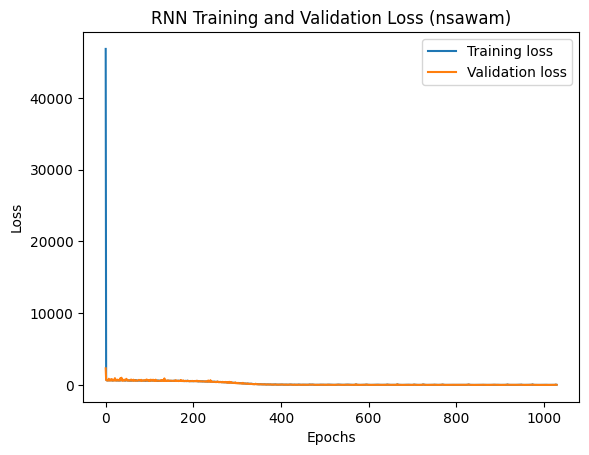

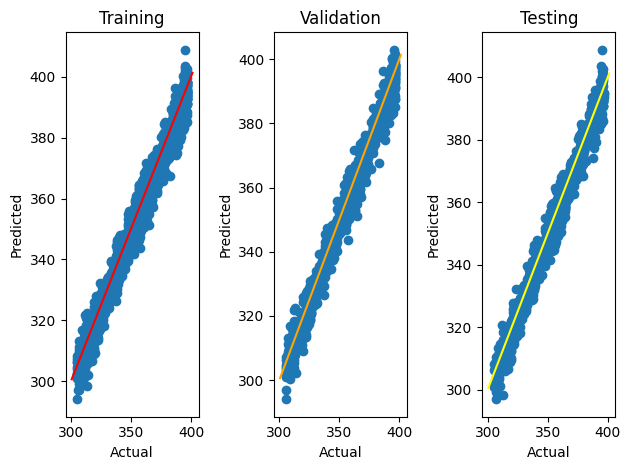

INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_rnn_saved_model\assets


INFO:tensorflow:Assets written to: D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_rnn_saved_model\assets


<Figure size 640x480 with 0 Axes>

In [ ]:
# Start MLflow run
with mlflow.start_run():

    # Log parameters
    mlflow.set_tag("programmer", "Berchie")
    mlflow.set_tag("model_type", "recurrent_neural_network")
    mlflow.set_tag("tensorflow_version", tf.__version__)
    mlflow.set_tag("experiment", "Nsawam")
    mlflow.log_param("Data-path", r"D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Nsawam.csv")
    mlflow.log_param('epochs', epochs)
    mlflow.log_param('batch_size', batch_size)

    # Recurrent neural network model architecture (LSTM)
    rnn_model = Sequential()
    rnn_model.add(LSTM(1000, activation="relu", input_shape=(x_train.shape[1], 1)))
    rnn_model.add(Dense(500, activation='relu'))
    rnn_model.add(Dense(250, activation='relu'))
    rnn_model.add(Dense(1, activation='linear'))

    # Log the model architecture using mlflow.tensorflow
    mlflow.tensorflow.log_model(rnn_model, 'rnn_model')

    rnn_model.summary()

    rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    earlyStop = EarlyStopping(monitor='val_loss',
                             mode='min',
                             patience=patience)

    history = rnn_model.fit(x_train_cnn, y_train,
                            epochs=epochs,
                            callbacks=[earlyStop],
                            batch_size=batch_size,
                            validation_data=(x_val_cnn, y_val),
                            verbose=1)

    # Log metrics
    mlflow.log_metric('nsawam_final_training_loss', history.history['loss'][-1])
    mlflow.log_metric('nsawam_final_validation_loss', history.history['val_loss'][-1])

    # Predictions
    train_preds = rnn_model.predict(x_train_cnn)
    val_preds = rnn_model.predict(x_val_cnn)
    test_preds = rnn_model.predict(x_test_cnn)

    # Evaluate on the test set
    rnn_results = rnn_model.evaluate(x_test_cnn, y_test)

    # MAE
    rnn_train_mae = mean_absolute_error(y_train, train_preds)
    rnn_val_mae = mean_absolute_error(y_val, val_preds)
    rnn_test_mae = rnn_results[1]

    # MSE
    rnn_train_mse = mean_squared_error(y_train, train_preds)
    rnn_val_mse = mean_squared_error(y_val, val_preds)
    rnn_test_mse = rnn_results[0]

    # RMSE
    rnn_train_rmse = np.sqrt(rnn_train_mse)
    rnn_val_rmse = np.sqrt(rnn_val_mse)
    rnn_test_rmse = np.sqrt(rnn_test_mse)

    # R-Square
    rnn_train_r2 = r2_score(y_train, train_preds)
    rnn_val_r2 = r2_score(y_val, val_preds)
    rnn_test_r2 = r2_score(y_test, test_preds)

    # MAPE
    rnn_train_mape = np.mean(np.abs((y_train - train_preds.flatten()) / y_train)) * 100
    rnn_val_mape = np.mean(np.abs((y_val - val_preds.flatten()) / y_val)) * 100
    rnn_test_mape = np.mean(np.abs((y_test - test_preds.flatten()) / y_test)) * 100

    # AIC calculation for the RNN
    n_samples_rnn = len(y_train)
    log_likelihood_rnn = -0.5 * n_samples_rnn * np.log(2 * np.pi * rnn_train_mse) - 0.5 * n_samples_rnn
    n_params_rnn = sum([np.prod(w.shape) for w in rnn_model.get_weights()])
    aic_rnn = -2 * log_likelihood_rnn + 2 * n_params_rnn

    # Log AIC as a metric
    mlflow.log_metric("nsawam_aic_rnn", aic_rnn)

    # Logging metrics
    mlflow.log_metric('nsawam_rnn_train_mae', rnn_train_mae)
    mlflow.log_metric('nsawam_rnn_val_mae', rnn_val_mae)
    mlflow.log_metric('nsawam_rnn_test_mae', rnn_test_mae)

    mlflow.log_metric('nsawam_rnn_train_mse', rnn_train_mse)
    mlflow.log_metric('nsawam_rnn_val_mse', rnn_val_mse)
    mlflow.log_metric('nsawam_rnn_test_mse', rnn_test_mse)

    mlflow.log_metric("nsawam_rnn_train_rmse", rnn_train_rmse)
    mlflow.log_metric("nsawam_rnn_val_rmse", rnn_val_rmse)
    mlflow.log_metric("nsawam_rnn_test_rmse", rnn_test_rmse)

    mlflow.log_metric("nsawam_rnn_train_r2", rnn_train_r2)
    mlflow.log_metric("nsawam_rnn_val_r2", rnn_val_r2)
    mlflow.log_metric("nsawam_rnn_test_r2", rnn_test_r2)

    mlflow.log_metric("nsawam_rnn_train_mape", rnn_train_mape)
    mlflow.log_metric("nsawam_rnn_val_mape", rnn_val_mape)
    mlflow.log_metric("nsawam_rnn_test_mape", rnn_test_mape)

    # Plot and save training/validation loss
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('RNN Training and Validation Loss (nsawam)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    loss_plot_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_rnn_loss_plot.png'

    plt.savefig(loss_plot_path)
    mlflow.log_artifact(loss_plot_path)

    # Log scatter plots
    fig, axes = plt.subplots(1, 3)

    # Training Results
    axes[0].scatter(x=y_train, y=train_preds)
    axes[0].set_xlabel("Actual", fontsize=10)
    axes[0].set_ylabel("Predicted", fontsize=10)
    axes[0].set_title("Training")

    x = np.linspace(*axes[0].get_xlim())
    axes[0].plot(x, x, color='red')

    # Validation Results
    axes[1].scatter(x=y_val, y=val_preds)
    axes[1].set_xlabel("Actual", fontsize=10)
    axes[1].set_ylabel("Predicted", fontsize=10)
    axes[1].set_title("Validation")

    x = np.linspace(*axes[1].get_xlim())
    axes[1].plot(x, x, color='orange')

    # Testing Results
    axes[2].scatter(x=y_test, y=test_preds)
    axes[2].set_xlabel("Actual", fontsize=10)
    axes[2].set_ylabel("Predicted", fontsize=10)
    axes[2].set_title("Testing")

    x = np.linspace(*axes[2].get_xlim())
    axes[2].plot(x, x, color='yellow')

    # Tight layout
    fig.tight_layout()

    plt.show()

    # Save scatter plot
    scatter_plot_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_rnn_scatter_plot.png'
    plt.savefig(scatter_plot_path)
    mlflow.log_artifact(scatter_plot_path)

    # Save the model as a TensorFlow SavedModel (optional)
    saved_model_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_rnn_saved_model'
    rnn_model.save(saved_model_path)

    # Log the SavedModel as an artifact
    mlflow.log_artifact(saved_model_path)
    mlflow.end_run()

### 4. Neural Network Ensemble

51/51 [==============================] - 1s 27ms/step
Epoch 1/20
26/26 [==============================] - 1s 10ms/step - loss: 14690.0098 - mae: 108.0879 - val_loss: 297.3387 - val_mae: 16.7289
Epoch 2/20
26/26 [==============================] - 0s 5ms/step - loss: 275.2328 - mae: 15.0234 - val_loss: 156.5390 - val_mae: 11.7839
Epoch 3/20
26/26 [==============================] - 0s 4ms/step - loss: 47.5247 - mae: 5.5089 - val_loss: 31.1102 - val_mae: 4.6561
Epoch 4/20
26/26 [==============================] - 0s 4ms/step - loss: 23.8592 - mae: 3.7543 - val_loss: 17.8646 - val_mae: 3.1988
Epoch 5/20
26/26 [==============================] - 0s 4ms/step - loss: 21.5252 - mae: 3.5396 - val_loss: 16.8790 - val_mae: 3.0625
Epoch 6/20
26/26 [==============================] - 0s 4ms/step - loss: 21.0785 - mae: 3.5067 - val_loss: 16.8014 - val_mae: 3.0556
Epoch 7/20
26/26 [==============================] - 0s 4ms/step - loss: 20.9269 - mae: 3.4822 - val_loss: 16.6547 - val_mae: 3.0403
Epoch 8/20

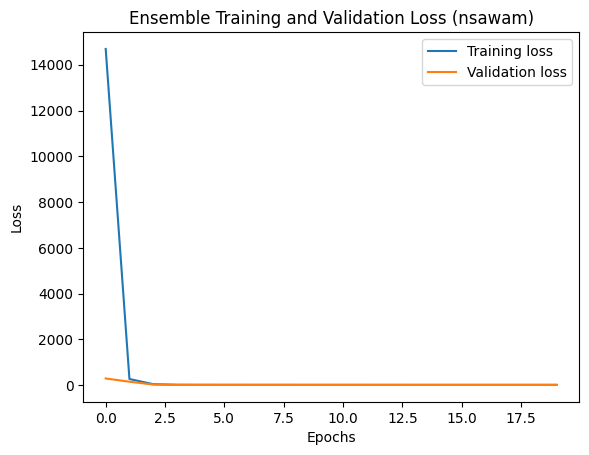

51/51 [==============================] - 0s 2ms/step


<Figure size 640x480 with 0 Axes>

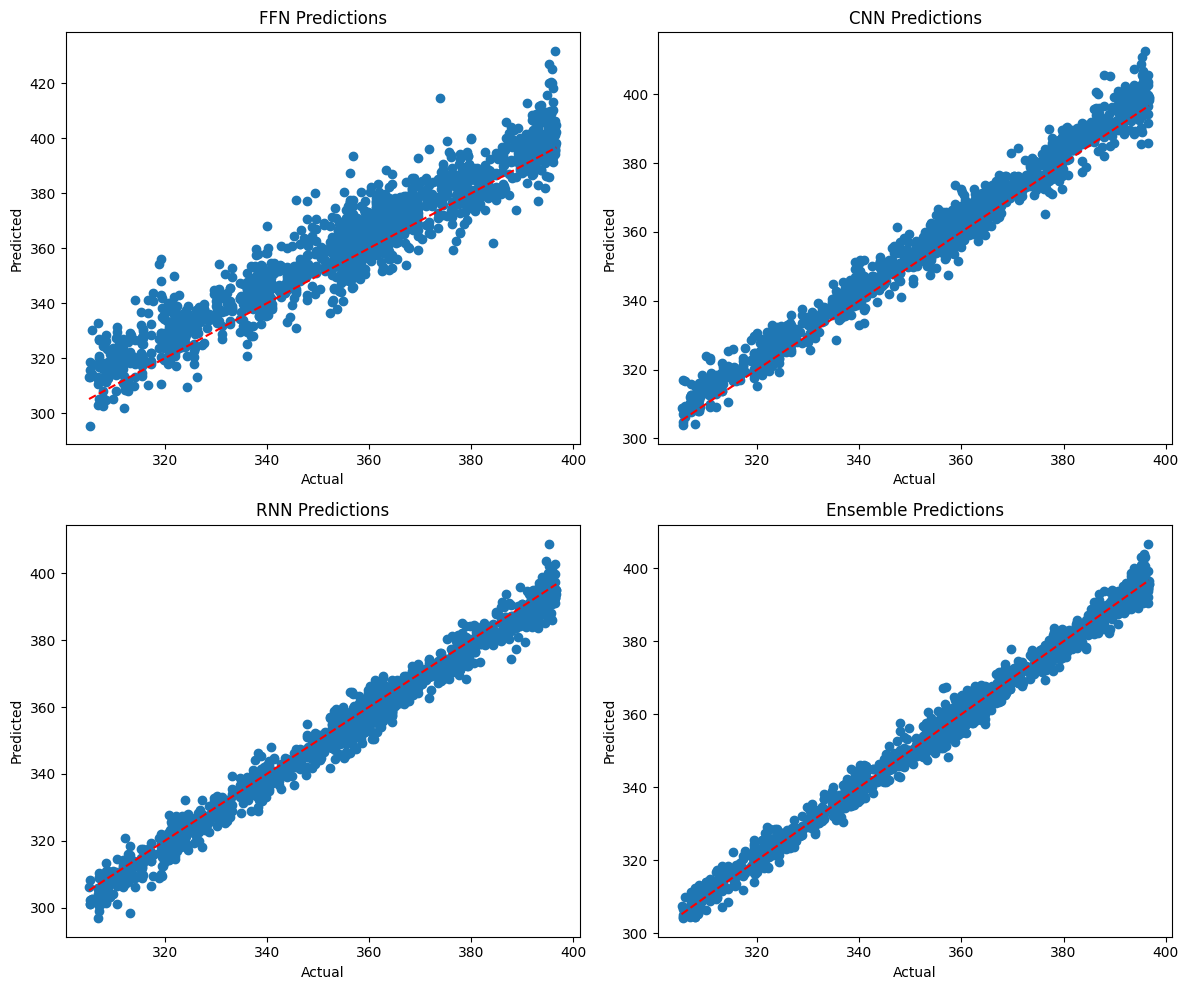

In [ ]:
import joblib

# Check if there is an active run
active_run = mlflow.active_run()
if active_run:
    # End the active run
    mlflow.end_run()

# Starting MLflow run
with mlflow.start_run():
    mlflow.set_tag("programmer", "Berchie")
    mlflow.set_tag("model_type", "neural_network_ensemble")
    mlflow.set_tag("tensorflow_version", tf.__version__)
    mlflow.set_tag("experiment", "Nsawam")
    mlflow.log_param("Data-path", r"D:\Groundwater level (GWL) changes\Groundwater level (GWL) changes data\Nsawam.csv")

    # Make predictions on the validation set using each model
    val_preds_ffn = ffn_model.predict(x_val)
    val_preds_cnn = cnn_model.predict(x_val_cnn)
    val_preds_rnn = rnn_model.predict(x_val_cnn)

    # Combine the predictions into a single input for the ensemble
    stacked_input_val = np.concatenate((val_preds_ffn, val_preds_cnn, val_preds_rnn), axis=1)

    # Create the Stacked Ensemble Model
    ensemble_model = Sequential()
    ensemble_model.add(Dense(100, activation='relu', input_shape=(3,)))
    ensemble_model.add(Dense(1, activation='linear'))

    # Compile the ensemble model
    ensemble_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    # Train the ensemble model on the stacked predictions
    history_ensemble = ensemble_model.fit(stacked_input_val, y_val, epochs=20, batch_size=batch_size, validation_split=0.2)

    # Log training and validation performance
    mlflow.log_metric("nsawam_ensemble_train_loss", history_ensemble.history['loss'][-1])
    mlflow.log_metric("nsawam_ensemble_val_loss", history_ensemble.history['val_loss'][-1])

    # Plot the loss for the ensemble during training and validation
    plt.plot(history_ensemble.history['loss'], label='Training loss')
    plt.plot(history_ensemble.history['val_loss'], label='Validation loss')
    plt.title('Ensemble Training and Validation Loss (nsawam)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Save the loss plot
    loss_plot_path_ensemble = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_ensemble_loss_plot.png'
    plt.savefig(loss_plot_path_ensemble)
    mlflow.log_artifact(loss_plot_path_ensemble)

    # Make predictions on the test set using each model
    test_preds_ffn = ffn_model.predict(x_test)
    test_preds_cnn = cnn_model.predict(x_test_cnn)
    test_preds_rnn = rnn_model.predict(x_test_cnn)

    # Combine the predictions into a single input for the ensemble
    stacked_input_test = np.concatenate((test_preds_ffn, test_preds_cnn, test_preds_rnn), axis=1)

    # Make predictions using the stacked ensemble
    ensemble_preds = stacked_ensemble.predict(stacked_input_test)

    # Scatter plots for individual models and ensemble
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Feed-Forward Neural Network
    axes[0, 0].scatter(x=y_test, y=test_preds_ffn)
    axes[0, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    axes[0, 0].set_xlabel("Actual", fontsize=10)
    axes[0, 0].set_ylabel("Predicted", fontsize=10)
    axes[0, 0].set_title("FFN Predictions")

    # Convolutional Neural Network
    axes[0, 1].scatter(x=y_test, y=test_preds_cnn)
    axes[0, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    axes[0, 1].set_xlabel("Actual", fontsize=10)
    axes[0, 1].set_ylabel("Predicted", fontsize=10)
    axes[0, 1].set_title("CNN Predictions")

    # Long Short-Term Memory RNN
    axes[1, 0].scatter(x=y_test, y=test_preds_rnn)
    axes[1, 0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    axes[1, 0].set_xlabel("Actual", fontsize=10)
    axes[1, 0].set_ylabel("Predicted", fontsize=10)
    axes[1, 0].set_title("RNN Predictions")

    # Stacked Ensemble
    axes[1, 1].scatter(x=y_test, y=ensemble_preds)
    axes[1, 1].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
    axes[1, 1].set_xlabel("Actual", fontsize=10)
    axes[1, 1].set_ylabel("Predicted", fontsize=10)
    axes[1, 1].set_title("Ensemble Predictions")

    # Tight layout
    fig.tight_layout()

    # Save scatter plots
    scatter_plots_path = r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_ensemble_scatter_plot.png'
    plt.savefig(scatter_plots_path)
    mlflow.log_artifact(scatter_plots_path)

    # Show the scatter plots
    plt.show()

    # Evaluate the performance of the stacked ensemble
    ensemble_mse = mean_squared_error(y_test, ensemble_preds)
    ensemble_mae = mean_absolute_error(y_test, ensemble_preds)
    ensemble_r2 = r2_score(y_test, ensemble_preds)
    ensemble_rmse = np.sqrt(ensemble_mse)
    ensemble_mape = np.mean(np.abs((y_val - ensemble_preds.flatten()) / y_val)) * 100

    # Log testing performance
    mlflow.log_metric("nsawam_ensemble_test_mae", ensemble_mae)
    mlflow.log_metric("nsawam_ensemble_test_mse", ensemble_mse)
    mlflow.log_metric("nsawam_ensemble_test_rmse", ensemble_rmse)
    mlflow.log_metric("nsawam_ensemble_test_r2", ensemble_r2)
    mlflow.log_metric("nsawam_ensemble_test_mape", ensemble_mape)

    # Get the number of parameters in the ensemble model
    num_params_ensemble = stacked_ensemble.count_params()

    # Calculate AIC
    max_log_likelihood = -0.5 * min(history_ensemble.history['val_loss'])
    aic_ensemble = 2 * num_params_ensemble - 2 * max_log_likelihood

    # Log AIC
    mlflow.log_metric("nsawam_ensemble_aic", aic_ensemble)

    # Saving the ensemble model as a pickle file
    joblib.dump(ensemble_model, r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_ensemble_model.pkl')

    # Log the ensemble model as an artifact
    mlflow.log_artifact(r'D:\RGT\Code\Practice\Deep Learning for GWL Changes\Artifacts\nsawam_ensemble_model.pkl')

### Print results

In [ ]:
print("Feed Forward Neural Network Results")
print("")
print("AIC: ", aic_ffn)
print(" ")
print("Training:")
print("Train MAE:", train_mae)
print("Train MSE:", train_mse)
print("Train RMSE:", train_rmse)
print("Train MAPE:", train_mape)
print("Train R-squared:", train_r2)

print(" ")
print("Validation:")
print("Validation MAE:", val_mae)
print("Validation MSE:", val_mse)
print("Validation RMSE:", val_rmse)
print("Validation MAPE:", val_mape)
print("Validation R-squared:", val_r2)

print(" ")
print("Testing:")
print("Test MAE:", test_mae)
print("Test MSE:", test_mse)
print("Test RMSE:", test_rmse)
print("Test MAPE:", test_mape)
print("Test R-squared:", test_r2)

Feed Forward Neural Network Results

AIC:  1293557.046534917
 
Training:
Train MAE: 7.609421
Train MSE: 89.2116
Train RMSE: 9.445189
Train MAPE: 2.161017991602421
Train R-squared: 0.8538587967144404
 
Validation:
Validation MAE: 7.638752
Validation MSE: 88.86683
Validation RMSE: 9.426921
Validation MAPE: 2.164895460009575
Validation R-squared: 0.8584854137037203
 
Testing:
Test MAE: 7.580087184906006
Test MSE: 89.556396484375
Test RMSE: 9.463424141629446
Test MAPE: 2.157140336930752
Test R-squared: 0.8488750328480237


In [ ]:
print("Convolutional Network Results")
print(" ")
print("AIC: ", aic_cnn)
print("")
print("Training:")
print("Train MAE:", cnn_train_mae)
print("Train MSE:", cnn_train_mse)
print("Train RMSE:", cnn_train_rmse)
print("Train MAPE:", cnn_train_mape)
print("Train R-squared:", cnn_train_r2)

print(" ")
print("Validation:")
print("Validation MAE:", cnn_val_mae)
print("Validation MSE:", cnn_val_mse)
print("Validation RMSE:", cnn_val_rmse)
print("Validation MAPE:", cnn_val_mape)
print("Validation R-squared:", cnn_val_r2)

print(" ")
print("Testing:")
print("Test MAE:", cnn_test_mae)
print("Test MSE:", cnn_test_mse)
print("Test RMSE:", cnn_test_rmse)
print("Test MAPE:", cnn_test_mape)
print("Test R-squared:", cnn_test_r2)

Convolutional Network Results
 
AIC:  1778914.954611722

Training:
Train MAE: 3.734724
Train MSE: 21.04528
Train RMSE: 4.5875134
Train MAPE: 1.0555536486208439
Train R-squared: 0.9655248599564581
 
Validation:
Validation MAE: 3.7244246
Validation MSE: 20.922024
Validation RMSE: 4.57406
Validation MAPE: 1.0526388883590698
Validation R-squared: 0.966683053618102
 
Testing:
Test MAE: 3.7450239658355713
Test MSE: 21.16853904724121
Test RMSE: 4.600928063689022
Test MAPE: 1.0584683157503605
Test R-squared: 0.9642784294392713


In [ ]:
print("Recurrent Neural Network")
print(" ")
print("AIC: ", aic_rnn)
print(" ")
print("Training:")
print("Train MAE:", rnn_train_mae)
print("Train MSE:", rnn_train_mse)
print("Train RMSE:", rnn_train_rmse)
print("Train MAPE:", rnn_train_mape)
print("Train R-squared:", rnn_train_r2)

print(" ")
print("Validation:")
print("Validation MAE:", rnn_val_mae)
print("Validation MSE:", rnn_val_mse)
print("Validation RMSE:", rnn_val_rmse)
print("Validation MAPE:", rnn_val_mape)
print("Validation R-squared:", rnn_val_r2)

print(" ")
print("Testing:")
print("Test MAE:", rnn_test_mae)
print("Test MSE:", rnn_test_mse)
print("Test RMSE:", rnn_test_rmse)
print("Test MAPE:", rnn_test_mape)
print("Test R-squared:", rnn_test_r2)

Recurrent Neural Network
 
AIC:  9285276.639908578
 
Training:
Train MAE: 2.8072333
Train MSE: 12.640843
Train RMSE: 3.5553963
Train MAPE: 0.7917080074548721
Train R-squared: 0.9792925114501733
 
Validation:
Validation MAE: 2.8108914
Validation MSE: 12.780505
Validation RMSE: 3.5749834
Validation MAPE: 0.7914463058114052
Validation R-squared: 0.9796478841202809
 
Testing:
Test MAE: 2.8035757541656494
Test MSE: 12.50118350982666
Test RMSE: 3.5357012755359665
Test MAPE: 0.7919697090983391
Test R-squared: 0.9789044510242367


In [ ]:
print("Neural Network Ensemble")
print(" ")
print("AIC: ", aic_ensemble)
print(" ")
print("Testing:")
print("Test MAE:", ensemble_mae)
print("Test MSE:", ensemble_mse)
print("Test RMSE:", ensemble_rmse)
print("Test MAPE:", ensemble_mape)
print("Test R-squared:", ensemble_r2)

Neural Network Ensemble
 
AIC:  1017.7332906723022
 
Testing:
Test MAE: 1.9174898
Test MSE: 6.109955
Test RMSE: 2.4718323
Test MAPE: 7.943204045295715
Test R-squared: 0.9896895488093083
